In [159]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import single, average, complete, fcluster, linkage
import re
from sklearn.metrics import adjusted_rand_score, jaccard_score
from itertools import combinations
from collections import defaultdict
from sklearn.cluster import AgglomerativeClustering

In [ ]:
mummer_file_path = '/home/ubuntu/wdir/PopGenStats_Project/data/B_longum/distances/mummer.tsv.gz'
skani_file_path = '/home/ubuntu/wdir/PopGenStats_Project/data/B_longum/distances/skani.tsv.gz'
parsnp_file_path = '/home/ubuntu/wdir/PopGenStats_Project/data/B_longum/distances/parsnp.tsv'

skder_file_path = '/home/ubuntu/wdir/PopGenStats_Project/data/B_longum/dereplication/skder.clusters.tsv.gz'
cidder_file_path = '/home/ubuntu/wdir/PopGenStats_Project/data/B_longum/dereplication/cidder.clusters.tsv.gz'
drep_file_path = '/home/ubuntu/wdir/PopGenStats_Project/data/B_longum/dereplication/drep.clusters.csv.gz'
galah_file_path = '/home/ubuntu/wdir/PopGenStats_Project/data/B_longum/dereplication/galah.clusters.tsv.gz'

meta_file_path = '/home/ubuntu/wdir/PopGenStats_Project/data/B_longum/dereplication/meta.tsv.gz'

In [161]:
mummer_matrix = pd.read_csv(mummer_file_path, sep='\t', index_col=0)
skani_matrix = pd.read_csv(skani_file_path, sep='\t')
parsnp_matrix = pd.read_csv(parsnp_file_path, sep='\t')

mummer_matrix['Tool'] = 'mummer'
skani_matrix['Tool'] = 'skANI'
parsnp_matrix['Tool'] = 'ParSNP'

In [162]:
def edit_accession_id(str):
    match = re.search(r'(GCF_|GCA_)\d{9}\.\d|flye.SQK-NBD\d{3}-\d{2}_barcode\d{2}', str)
    if match:
        return match.group(0)
    return None

In [163]:
# mummer_matrix.rename(columns = {'avg_identity1':'ANI_1', 'avg_identity2':'ANI_2'}, inplace = True)
mummer_matrix['score1'] = mummer_matrix['avg_identity1'] * (mummer_matrix['prc_aligned1'] / 100)
mummer_matrix['score2'] = mummer_matrix['avg_identity2'] * (mummer_matrix['prc_aligned2'] / 100)

mummer_matrix['s1'] = mummer_matrix['s1'].apply(edit_accession_id)
mummer_matrix['s2'] = mummer_matrix['s2'].apply(edit_accession_id)

mummer_sample_names = sorted(set(mummer_matrix['s1']) | set(mummer_matrix['s2']))
mummer_mapper = {name: f'sample{idx}' for idx, name in enumerate(mummer_sample_names)}

mummer_matrix['ref'] = mummer_matrix['s1'].map(mummer_mapper)
mummer_matrix['query'] = mummer_matrix['s2'].map(mummer_mapper)

mummer_matrix

,prc_aligned1,prc_aligned2,avg_identity1,avg_identity2,s1,s2,Tool,score1,score2,ref,query
0,100.0000,100.0000,99.9900,99.9900,flye.SQK-NBD114-96_barcode49,flye.SQK-NBD114-96_barcode50,mummer,99.990000,99.990000,sample567,sample568
1,88.1659,81.4325,98.8715,98.8715,flye.SQK-NBD114-96_barcode49,flye.SQK-NBD114-96_barcode51,mummer,87.170948,80.513534,sample567,sample569
2,86.3207,81.5670,98.9606,98.9606,flye.SQK-NBD114-96_barcode49,flye.SQK-NBD114-96_barcode52,mummer,85.423483,80.719193,sample567,sample570
3,100.0000,100.0000,99.9900,99.9900,flye.SQK-NBD114-96_barcode49,flye.SQK-NBD114-96_barcode53,mummer,99.990000,99.990000,sample567,sample571
4,85.9834,84.8052,98.8592,98.8592,flye.SQK-NBD114-96_barcode49,flye.SQK-NBD114-96_barcode54,mummer,85.002501,83.837742,sample567,sample572
...,...,...,...,...,...,...,...,...,...,...,...
188186,77.7822,73.3819,96.6381,96.6381,GCF_925297675.1,GCF_934630425.1,mummer,75.167240,70.914874,sample563,sample565
188187,84.3246,87.7342,98.6609,98.6609,GCF_925297675.1,GCF_934675445.1,mummer,83.195409,86.559351,sample563,sample566
188188,76.6487,73.2226,96.2964,96.2964,GCF_925300395.1,GCF_934630425.1,mummer,73.809939,70.510728,sample564,sample565
188189,75.2502,79.3385,97.1016,97.1016,GCF_925300395.1,GCF_934675445.1,mummer,73.069148,77.038953,sample564,sample566


In [164]:
# skani_matrix.rename(columns = {'Ref_file': 's1', 'Query_file': 's2', 'ANI':'ANI_1', 'Align_fraction_ref': 'prc_aligned1', 'Align_fraction_query': 'prc_aligned2'}, inplace = True)
skani_matrix['score1'] = skani_matrix['ANI'] * (skani_matrix['Align_fraction_ref'] / 100)
skani_matrix['score2'] = skani_matrix['ANI'] * (skani_matrix['Align_fraction_query'] / 100)

skani_matrix['Ref_file'] = skani_matrix['Ref_file'].apply(edit_accession_id)
skani_matrix['Query_file'] = skani_matrix['Query_file'].apply(edit_accession_id)

skani_sample_names = sorted(set(skani_matrix['Ref_file']) | set(skani_matrix['Query_file']))
skani_mapper = {name: f'sample{idx}' for idx, name in enumerate(skani_sample_names)}

skani_matrix['ref'] = skani_matrix['Ref_file'].map(skani_mapper)
skani_matrix['query'] = skani_matrix['Query_file'].map(skani_mapper)

skani_matrix

,Ref_file,Query_file,ANI,Align_fraction_ref,Align_fraction_query,Ref_name,Query_name,Tool,score1,score2,ref,query
0,flye.SQK-NBD114-96_barcode49,GCF_002833175.1,98.73,83.96,78.95,contig_1 rotated=True rotated_gene=dnaA,NZ_PJED01000001.1 Bifidobacterium longum strai...,skANI,82.893708,77.947335,sample567,sample142
1,flye.SQK-NBD114-96_barcode49,GCF_004334855.1,98.43,83.84,78.57,contig_1 rotated=True rotated_gene=dnaA,NZ_SHTT01000001.1 Bifidobacterium longum subsp...,skANI,82.523712,77.336451,sample567,sample331
2,flye.SQK-NBD114-96_barcode49,GCF_026520385.1,98.74,82.42,79.50,contig_1 rotated=True rotated_gene=dnaA,NZ_WMFR01000010.1 Bifidobacterium longum subsp...,skANI,81.381508,78.498300,sample567,sample520
3,flye.SQK-NBD114-96_barcode49,GCA_958435375.1,98.60,82.91,81.25,contig_1 rotated=True rotated_gene=dnaA,CAUBFY010000001.1 MAG TPA_asm: Bifidobacterium...,skANI,81.749260,80.112500,sample567,sample63
4,flye.SQK-NBD114-96_barcode49,GCF_004333265.1,98.84,84.66,81.85,contig_1 rotated=True rotated_gene=dnaA,NZ_SHRW01000001.1 Bifidobacterium longum subsp...,skANI,83.677944,80.900540,sample567,sample252
...,...,...,...,...,...,...,...,...,...,...,...,...
188186,GCF_016759765.1,GCF_020531735.1,98.74,86.11,84.17,NZ_JAERWG010000001.1 Bifidobacterium longum su...,NZ_JAJBBY010000010.1 Bifidobacterium longum su...,skANI,85.025014,83.109458,sample410,sample489
188187,GCF_016759765.1,GCF_017312565.1,98.90,84.12,85.80,NZ_JAERWG010000001.1 Bifidobacterium longum su...,NZ_BNGZ01000001.1 Bifidobacterium longum subsp...,skANI,83.194680,84.856200,sample410,sample422
188188,GCF_016759765.1,GCF_030414115.1,98.50,84.51,79.61,NZ_JAERWG010000001.1 Bifidobacterium longum su...,NZ_QCZN01000001.1 Bifidobacterium longum subsp...,skANI,83.242350,78.415850,sample410,sample544
188189,GCF_016759765.1,GCF_019131725.1,98.89,87.36,85.83,NZ_JAERWG010000001.1 Bifidobacterium longum su...,NZ_JAHOMU010000010.1 Bifidobacterium longum st...,skANI,86.390304,84.877287,sample410,sample477


SANITY CHECK THAT SAMPLES ARE WITHIN THE SPECIES-LEVEL ANI THRESHOLD

In [165]:
skani_matrix['ANI'].min(), mummer_matrix['avg_identity1'].min()

(np.float64(95.33), np.float64(96.1288))

HOW MANY SAMPLES ARE OUR LAB'S ISOLATES?

In [166]:
unique_barcodes = skani_matrix['Ref_file'].str.contains(r'SQK-NBD114-96_barcode\d{2}', regex=True)
unique_names = skani_matrix[unique_barcodes]['Ref_file'].unique()
len(unique_names)

47

In [167]:
parsnp_matrix['ANI_1'] = 100 - parsnp_matrix['prc']

parsnp_matrix['p1'] = parsnp_matrix['p1'].apply(edit_accession_id)
parsnp_matrix['p2'] = parsnp_matrix['p2'].apply(edit_accession_id)

parsnp_sample_names = sorted(set(parsnp_matrix['p1']) | set(parsnp_matrix['p2']))
parsnp_mapper = {name: f'sample{idx}' for idx, name in enumerate(parsnp_sample_names)}

parsnp_matrix['ref'] = parsnp_matrix['p1'].map(parsnp_mapper)
parsnp_matrix['query'] = parsnp_matrix['p2'].map(parsnp_mapper)

parsnp_matrix

,p1,p2,diff,prc,Tool,ANI_1,ref,query
0,GCF_003474905.1,GCF_004333165.1,2118,4.508973,ParSNP,95.491027,sample210,sample247
1,GCF_003474905.1,GCF_002833125.1,1896,4.036361,ParSNP,95.963639,sample210,sample140
2,GCF_003474905.1,GCF_003094935.1,2113,4.498329,ParSNP,95.501671,sample210,sample154
3,GCF_003474905.1,GCF_004334445.1,1976,4.206672,ParSNP,95.793328,sample210,sample312
4,GCF_003474905.1,GCF_000730045.1,1870,3.981010,ParSNP,96.018990,sample210,sample93
...,...,...,...,...,...,...,...,...
188800,GCF_003471355.1,flye.SQK-NBD114-96_barcode75,2270,4.832563,ParSNP,95.167437,sample203,sample592
188801,GCF_003471355.1,GCA_959018325.1,2294,4.883657,ParSNP,95.116343,sample203,sample67
188802,GCF_004332895.1,flye.SQK-NBD114-96_barcode75,2423,5.158282,ParSNP,94.841718,sample234,sample592
188803,GCF_004332895.1,GCA_959018325.1,2245,4.779341,ParSNP,95.220659,sample234,sample67


NUMBER OF SNPS BOXPLOTS

In [168]:
parsnp_matrix['alignment_size'] = parsnp_matrix['diff'] / (parsnp_matrix['prc']/100)
parsnp_matrix

,p1,p2,diff,prc,Tool,ANI_1,ref,query,alignment_size
0,GCF_003474905.1,GCF_004333165.1,2118,4.508973,ParSNP,95.491027,sample210,sample247,46973.0
1,GCF_003474905.1,GCF_002833125.1,1896,4.036361,ParSNP,95.963639,sample210,sample140,46973.0
2,GCF_003474905.1,GCF_003094935.1,2113,4.498329,ParSNP,95.501671,sample210,sample154,46973.0
3,GCF_003474905.1,GCF_004334445.1,1976,4.206672,ParSNP,95.793328,sample210,sample312,46973.0
4,GCF_003474905.1,GCF_000730045.1,1870,3.981010,ParSNP,96.018990,sample210,sample93,46973.0
...,...,...,...,...,...,...,...,...,...
188800,GCF_003471355.1,flye.SQK-NBD114-96_barcode75,2270,4.832563,ParSNP,95.167437,sample203,sample592,46973.0
188801,GCF_003471355.1,GCA_959018325.1,2294,4.883657,ParSNP,95.116343,sample203,sample67,46973.0
188802,GCF_004332895.1,flye.SQK-NBD114-96_barcode75,2423,5.158282,ParSNP,94.841718,sample234,sample592,46973.0
188803,GCF_004332895.1,GCA_959018325.1,2245,4.779341,ParSNP,95.220659,sample234,sample67,46973.0


In [169]:
parsnp_snp_matrix = parsnp_matrix[['p1', 'p2', 'diff', 'prc']]
parsnp_snp_matrix

,p1,p2,diff,prc
0,GCF_003474905.1,GCF_004333165.1,2118,4.508973
1,GCF_003474905.1,GCF_002833125.1,1896,4.036361
2,GCF_003474905.1,GCF_003094935.1,2113,4.498329
3,GCF_003474905.1,GCF_004334445.1,1976,4.206672
4,GCF_003474905.1,GCF_000730045.1,1870,3.981010
...,...,...,...,...
188800,GCF_003471355.1,flye.SQK-NBD114-96_barcode75,2270,4.832563
188801,GCF_003471355.1,GCA_959018325.1,2294,4.883657
188802,GCF_004332895.1,flye.SQK-NBD114-96_barcode75,2423,5.158282
188803,GCF_004332895.1,GCA_959018325.1,2245,4.779341


Text(0, 0.5, 'SNP count')

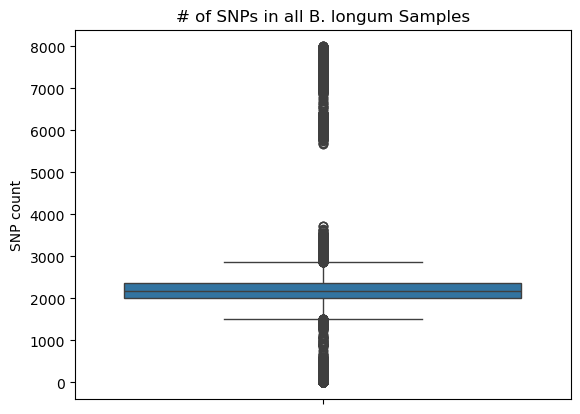

In [277]:
sns.boxplot(parsnp_snp_matrix, y='diff')
plt.title('# of SNPs in all B. longum Samples')
plt.ylabel('SNP count')

SUBSPECIES IDENTITIES

In [171]:
meta_matrix = pd.read_csv(meta_file_path, sep='\t', index_col=0)
meta_matrix['accession'] = meta_matrix['accession'].apply(edit_accession_id)

meta_matrix.rename(columns={"accession": "Ref_file"}, inplace=True)

meta_matrix

,Ref_file,ambiguous_bases,checkm2_completeness,checkm2_contamination,checkm2_model,checkm_completeness,checkm_contamination,checkm_marker_count,checkm_marker_lineage,checkm_marker_set_count,...,ssu_silva_blast_bitscore,ssu_silva_blast_evalue,ssu_silva_blast_perc_identity,ssu_silva_blast_subject_id,ssu_silva_taxonomy,total_gap_length,trna_aa_count,trna_count,trna_selenocysteine_count,species
418,GCF_002833015.1,0,99.96,0.07,Specific,100.00,0.00,476,f__Bifidobacteriaceae (UID1462),217,...,2813,0,100,CP031133.1461055.1462589,Bacteria;Actinobacteriota;Actinobacteria;Bifid...,0,19,56,0,Bifidobacterium longum
1319,GCF_003473205.1,0,99.99,0.01,Specific,100.00,0.00,476,f__Bifidobacteriaceae (UID1462),217,...,2813,0,100,CP031133.1461055.1462589,Bacteria;Actinobacteriota;Actinobacteria;Bifid...,75,19,55,0,Bifidobacterium longum
2844,GCF_020008065.1,0,99.90,0.01,Specific,100.00,0.00,476,f__Bifidobacteriaceae (UID1462),217,...,2808,0,99.934,CP031133.1461055.1462589,Bacteria;Actinobacteriota;Actinobacteria;Bifid...,0,19,57,0,Bifidobacterium longum
3546,GCF_020072545.1,0,99.99,0.19,Specific,100.00,0.00,476,f__Bifidobacteriaceae (UID1462),217,...,2813,0,100,CP031133.1461055.1462589,Bacteria;Actinobacteriota;Actinobacteria;Bifid...,0,19,58,0,Bifidobacterium longum
4495,GCF_002276185.1,0,99.96,0.07,Specific,100.00,0.12,476,f__Bifidobacteriaceae (UID1462),217,...,2813,0,100,CP031133.1461055.1462589,Bacteria;Actinobacteriota;Actinobacteria;Bifid...,0,19,57,0,Bifidobacterium longum
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578245,GCF_005844715.1,0,99.97,0.15,Specific,100.00,0.46,476,f__Bifidobacteriaceae (UID1462),217,...,2813,0,100,CP031133.1461055.1462589,Bacteria;Actinobacteriota;Actinobacteria;Bifid...,96,19,57,0,Bifidobacterium longum
580263,GCF_004324325.1,22,99.99,1.67,Specific,99.54,1.96,476,f__Bifidobacteriaceae (UID1462),217,...,1435,0,100,CP031133.1461055.1462589,Bacteria;Actinobacteriota;Actinobacteria;Bifid...,0,19,63,0,Bifidobacterium longum
580600,GCF_020181415.1,0,99.99,0.33,Specific,100.00,0.00,476,f__Bifidobacteriaceae (UID1462),217,...,2802,0,99.869,CP002794.163159.164695,Bacteria;Actinobacteriota;Actinobacteria;Bifid...,0,19,75,0,Bifidobacterium longum
580861,GCA_008670925.1,0,99.77,0.07,Specific,98.56,0.73,476,f__Bifidobacteriaceae (UID1462),217,...,none,none,none,none,none,0,19,57,0,Bifidobacterium longum


In [172]:
def extract_tax(values, target_rank):
    values = values.split(';')
    for value in values:
        rank, value = value.split('__')
        if rank == target_rank:
            return value
    return np.nan

meta_matrix['gtdb_sb'] = meta_matrix['ncbi_taxonomy_unfiltered'].apply(lambda tax: extract_tax(tax, 'sb'))
meta_matrix['gtdb_sb']

418                                        NaN
1319                                       NaN
2844      Bifidobacterium longum subsp. longum
3546      Bifidobacterium longum subsp. longum
4495                                       NaN
                          ...                 
578245                                     NaN
580263    Bifidobacterium longum subsp. longum
580600                                     NaN
580861                                     NaN
582918    Bifidobacterium longum subsp. longum
Name: gtdb_sb, Length: 567, dtype: object

In [173]:
subsp_meta_matrix = meta_matrix[meta_matrix['gtdb_sb'].notnull()]
subsp_meta_matrix = subsp_meta_matrix.filter(items=['Ref_file', 'gtdb_sb'])
subsp_meta_matrix.rename(columns={"gtdb_sb": "gtdb_sb_ref"}, inplace=True)
subsp_meta_matrix

,Ref_file,gtdb_sb_ref
2844,GCF_020008065.1,Bifidobacterium longum subsp. longum
3546,GCF_020072545.1,Bifidobacterium longum subsp. longum
6242,GCF_016759825.1,Bifidobacterium longum subsp. longum
6848,GCF_016634435.1,Bifidobacterium longum subsp. longum
11109,GCF_001686145.1,Bifidobacterium longum subsp. longum
...,...,...
572541,GCF_000166315.1,Bifidobacterium longum subsp. longum
575476,GCF_020353915.1,Bifidobacterium longum subsp. longum
576211,GCF_004332725.1,Bifidobacterium longum subsp. longum
580263,GCF_004324325.1,Bifidobacterium longum subsp. longum


In [174]:
subsp_meta_matrix_query = subsp_meta_matrix.copy()
subsp_meta_matrix_query.rename(columns={"Ref_file": "Query_file", "gtdb_sb_ref": "gtdb_sb_query"}, inplace=True)

subsp_dist_matrix = pd.merge(skani_matrix, subsp_meta_matrix, on='Ref_file')
subsp_dist_matrix = pd.merge(subsp_dist_matrix, subsp_meta_matrix_query, on='Query_file')

subsp_dist_matrix['gtdb_sb_ref'] = subsp_dist_matrix['gtdb_sb_ref'].apply(lambda x: x.split()[-1])
subsp_dist_matrix['gtdb_sb_query'] = subsp_dist_matrix['gtdb_sb_query'].apply(lambda x: x.split()[-1])

subsp_dist_matrix

,Ref_file,Query_file,ANI,Align_fraction_ref,Align_fraction_query,Ref_name,Query_name,Tool,score1,score2,ref,query,gtdb_sb_ref,gtdb_sb_query
0,GCF_004334855.1,GCF_026520385.1,98.86,85.11,87.61,NZ_SHTT01000001.1 Bifidobacterium longum subsp...,NZ_WMFR01000010.1 Bifidobacterium longum subsp...,skANI,84.139746,86.611246,sample331,sample520,longum,longum
1,GCF_004334855.1,GCF_017132775.1,98.71,77.41,79.23,NZ_SHTT01000001.1 Bifidobacterium longum subsp...,NZ_CP070995.1 Bifidobacterium longum subsp. lo...,skANI,76.411411,78.207933,sample331,sample417,longum,longum
2,GCF_004334855.1,GCF_006438975.1,98.57,81.05,83.14,NZ_SHTT01000001.1 Bifidobacterium longum subsp...,NZ_SZNG01000010.1 Bifidobacterium longum subsp...,skANI,79.890985,81.951098,sample331,sample338,longum,longum
3,GCF_004334855.1,GCF_017312605.1,98.95,80.65,83.15,NZ_SHTT01000001.1 Bifidobacterium longum subsp...,NZ_BNHB01000001.1 Bifidobacterium longum subsp...,skANI,79.803175,82.276925,sample331,sample424,longum,longum
4,GCF_004334855.1,GCF_016634435.1,98.84,79.94,86.01,NZ_SHTT01000001.1 Bifidobacterium longum subsp...,NZ_WKJF01000001.1 Bifidobacterium longum subsp...,skANI,79.012696,85.012284,sample331,sample400,longum,longum
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29398,GCF_016759765.1,GCF_016882605.1,96.74,75.57,75.98,NZ_JAERWG010000001.1 Bifidobacterium longum su...,NZ_WHVJ01000001.1 Bifidobacterium longum subsp...,skANI,73.106418,73.503052,sample410,sample415,longum,suillum
29399,GCF_016759765.1,GCF_020531735.1,98.74,86.11,84.17,NZ_JAERWG010000001.1 Bifidobacterium longum su...,NZ_JAJBBY010000010.1 Bifidobacterium longum su...,skANI,85.025014,83.109458,sample410,sample489,longum,infantis
29400,GCF_016759765.1,GCF_017312565.1,98.90,84.12,85.80,NZ_JAERWG010000001.1 Bifidobacterium longum su...,NZ_BNGZ01000001.1 Bifidobacterium longum subsp...,skANI,83.194680,84.856200,sample410,sample422,longum,longum
29401,GCF_016759765.1,GCF_030414115.1,98.50,84.51,79.61,NZ_JAERWG010000001.1 Bifidobacterium longum su...,NZ_QCZN01000001.1 Bifidobacterium longum subsp...,skANI,83.242350,78.415850,sample410,sample544,longum,longum


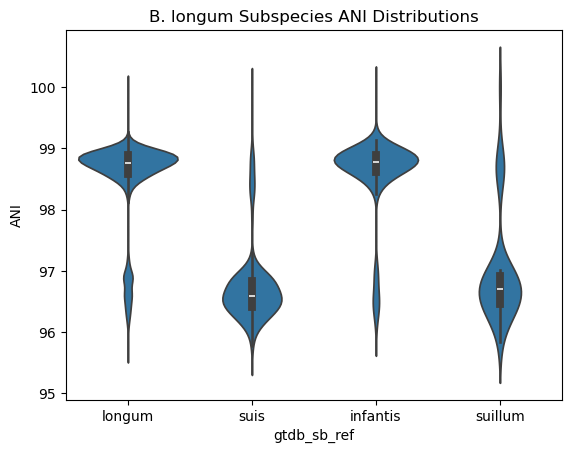

In [175]:
sns.violinplot(subsp_dist_matrix, x='gtdb_sb_ref', y='ANI')
plt.title('B. longum Subspecies ANI Distributions')
plt.show()

In [176]:
grouped_df = subsp_dist_matrix.groupby(['gtdb_sb_ref', 'gtdb_sb_query'])['ANI'].mean().reset_index()

subsp_heatmap_df = grouped_df.pivot(index='gtdb_sb_ref', columns='gtdb_sb_query', values='ANI')
subsp_heatmap_df

gtdb_sb_query,infantis,longum,suillum,suis
gtdb_sb_ref,,,,
infantis,98.894286,98.630000,96.612778,96.610800
longum,98.724592,98.582424,96.593388,96.693941
suillum,96.376667,96.921270,100.000000,NaN
suis,96.424783,96.663419,98.683889,98.551333


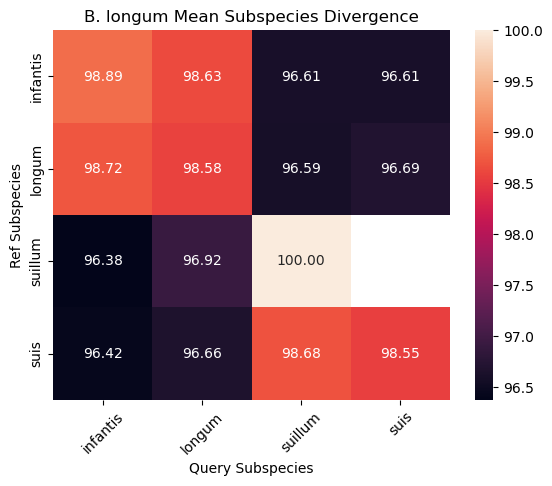

In [177]:
sns.heatmap(subsp_heatmap_df, annot=True, fmt='.2f')
plt.xticks(rotation=45) 
plt.title('B. longum Mean Subspecies Divergence')
plt.xlabel('Query Subspecies')
plt.ylabel('Ref Subspecies')
plt.show()

/var/folders/c4/74mrz72x32z07ktyfxzn15cw0000gn/T/ipykernel_33556/1777119774.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=query_subsp, y=ani, data=subset_df, palette=[colors[i]])
/var/folders/c4/74mrz72x32z07ktyfxzn15cw0000gn/T/ipykernel_33556/1777119774.py:12: UserWarning: 
The palette list has fewer values (1) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.violinplot(x=query_subsp, y=ani, data=subset_df, palette=[colors[i]])


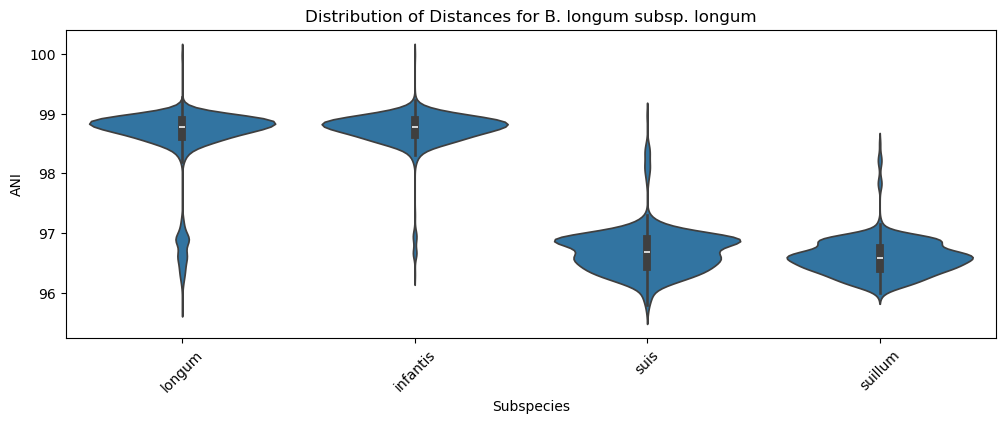

/var/folders/c4/74mrz72x32z07ktyfxzn15cw0000gn/T/ipykernel_33556/1777119774.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=query_subsp, y=ani, data=subset_df, palette=[colors[i]])
/var/folders/c4/74mrz72x32z07ktyfxzn15cw0000gn/T/ipykernel_33556/1777119774.py:12: UserWarning: 
The palette list has fewer values (1) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.violinplot(x=query_subsp, y=ani, data=subset_df, palette=[colors[i]])


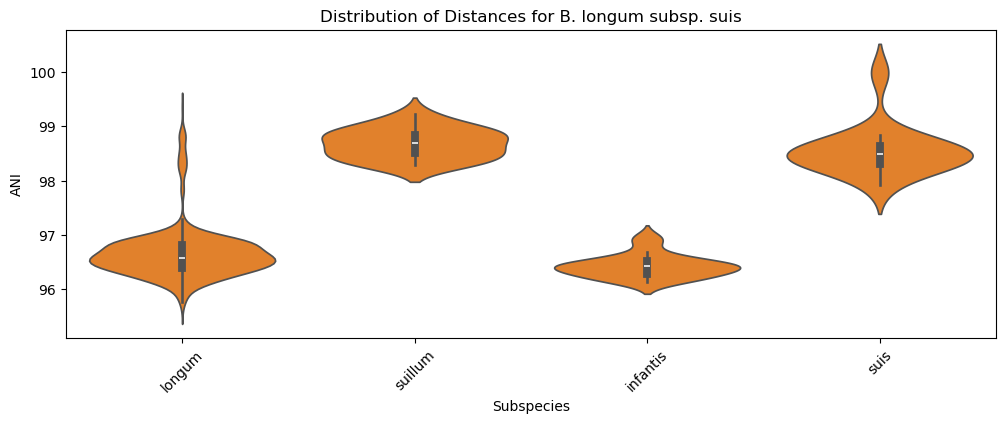

/var/folders/c4/74mrz72x32z07ktyfxzn15cw0000gn/T/ipykernel_33556/1777119774.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=query_subsp, y=ani, data=subset_df, palette=[colors[i]])
/var/folders/c4/74mrz72x32z07ktyfxzn15cw0000gn/T/ipykernel_33556/1777119774.py:12: UserWarning: 
The palette list has fewer values (1) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.violinplot(x=query_subsp, y=ani, data=subset_df, palette=[colors[i]])


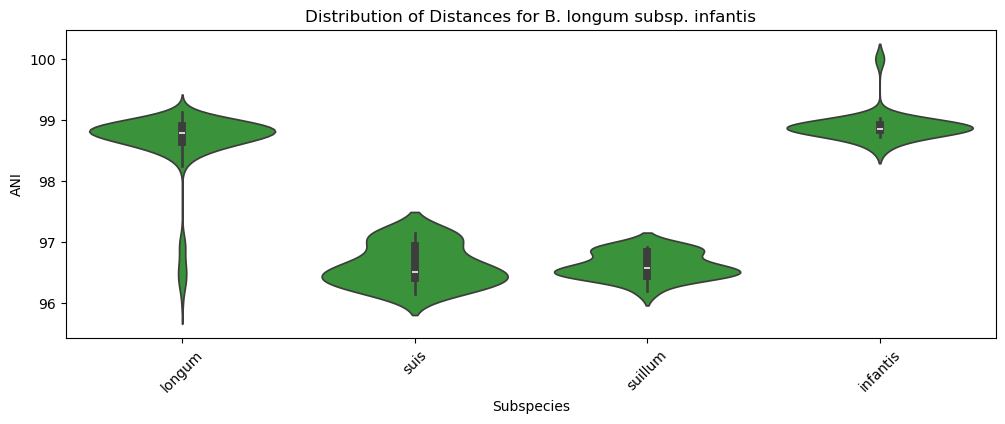

/var/folders/c4/74mrz72x32z07ktyfxzn15cw0000gn/T/ipykernel_33556/1777119774.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=query_subsp, y=ani, data=subset_df, palette=[colors[i]])
/var/folders/c4/74mrz72x32z07ktyfxzn15cw0000gn/T/ipykernel_33556/1777119774.py:12: UserWarning: 
The palette list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.violinplot(x=query_subsp, y=ani, data=subset_df, palette=[colors[i]])


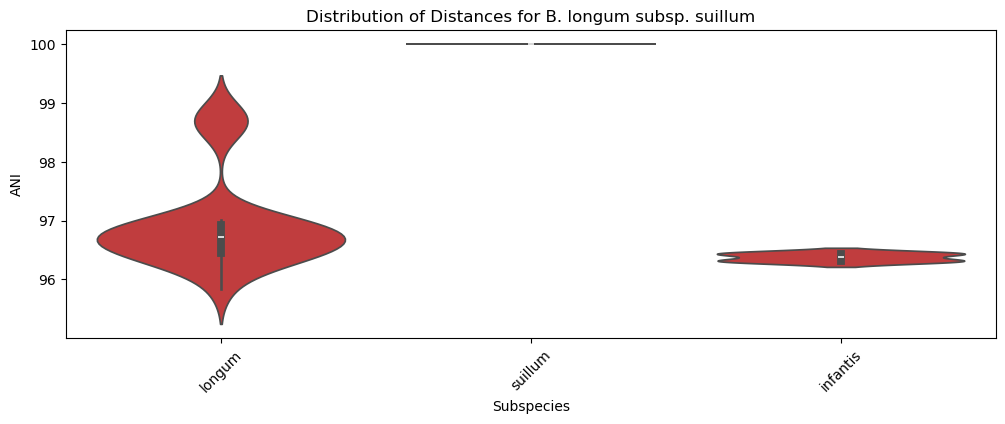

In [178]:
ref_subsp = 'gtdb_sb_ref'
query_subsp = 'gtdb_sb_query'
ani = 'ANI'

subspecies = subsp_dist_matrix[ref_subsp].unique()
colors = sns.color_palette("tab10", len(subspecies))

for i, classification in enumerate(subspecies):
    subset_df = subsp_dist_matrix[subsp_dist_matrix[ref_subsp] == classification]
    
    plt.figure(figsize=(12,4))
    sns.violinplot(x=query_subsp, y=ani, data=subset_df, palette=[colors[i]])
    plt.title(f'Distribution of Distances for B. longum subsp. {classification}')
    plt.xlabel('Subspecies')
    plt.ylabel('ANI')
    plt.xticks(rotation=45)
    plt.show()

MAKE CLUSTERING MATRICES FOR EACH TOOL

In [179]:
mummer_diagonal_data = []
for sample in mummer_sample_names:
    mummer_diagonal_data.append({
        'prc_aligned1': 100,
        'prc_aligned2': 100,
        'avg_identity1': 100,
        'avg_identity2': 100,
        's1': sample,
        's2': sample,
        'ref': mummer_mapper[sample],
        'query': mummer_mapper[sample],
        'score1': 100,
        'score2': 100,
        'Tool': 'mummer'
    })

mummer_diagonal_df = pd.DataFrame(mummer_diagonal_data)
mummer_matrix = pd.concat([mummer_matrix, mummer_diagonal_df], ignore_index=True)

mummer_matrix = mummer_matrix.sort_values(by=['s1', 's2']).reset_index(drop=True)
mummer_matrix = mummer_matrix.drop_duplicates(['ref', 'query'])

mummer_upper_triangle = mummer_matrix.pivot(index='ref', columns='query', values='avg_identity1').fillna(0)
mummer_upper_triangle = mummer_upper_triangle[sorted(mummer_upper_triangle.columns)]

mummer_lower_triangle = mummer_matrix.pivot(index='query', columns='ref', values='avg_identity2').fillna(0)
mummer_lower_triangle = mummer_lower_triangle[sorted(mummer_lower_triangle.columns)]

new_mummer_matrix = mummer_upper_triangle + mummer_lower_triangle
new_mummer_matrix[:] = np.where(new_mummer_matrix==200, 100, new_mummer_matrix)

new_mummer_matrix

query,sample0,sample1,sample10,sample100,sample101,sample102,sample103,sample104,sample105,sample106,...,sample90,sample91,sample92,sample93,sample94,sample95,sample96,sample97,sample98,sample99
ref,,,,,,,,,,,,,,,,,,,,,
sample0,100.0000,99.6903,98.5399,96.5410,98.7323,98.5985,98.7090,98.7895,98.7261,98.7446,...,98.6648,98.7282,98.6202,98.6879,98.6070,98.8501,98.6933,96.7532,98.6945,96.5274
sample1,99.6903,100.0000,98.5908,96.6275,98.7693,98.6603,98.7945,98.8440,98.7802,98.8185,...,98.7244,98.7974,98.6603,98.7303,98.6527,98.8974,98.7145,96.8644,98.7563,96.6113
sample10,98.5399,98.5908,100.0000,96.5949,98.7473,98.6335,98.7264,98.7734,98.7186,98.6497,...,98.6883,98.7205,98.7083,98.6726,98.7086,98.8092,98.7276,96.5948,98.8238,96.5849
sample100,96.5410,96.6275,96.5949,100.0000,96.6704,96.6531,96.5621,96.7005,96.7157,96.7754,...,96.6508,96.7058,96.6329,96.6370,96.6043,96.7562,96.6808,98.1772,96.5976,99.9810
sample101,98.7323,98.7693,98.7473,96.6704,100.0000,98.8628,98.8140,98.9697,98.8419,98.8637,...,98.9301,99.0346,98.9264,98.9181,98.9458,98.9822,98.9447,96.9289,98.9545,96.6633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sample95,98.8501,98.8974,98.8092,96.7562,98.9822,98.7527,98.9543,98.9592,98.9514,98.9759,...,98.9736,99.0281,98.8169,98.9028,98.9077,100.0000,99.0346,96.9433,99.0357,96.7437
sample96,98.6933,98.7145,98.7276,96.6808,98.9447,98.6192,98.7921,98.8315,98.6668,98.7644,...,98.8120,98.8802,98.8224,98.7742,98.8692,99.0346,100.0000,96.8213,98.8478,96.6653
sample97,96.7532,96.8644,96.5948,98.1772,96.9289,96.8488,96.8292,96.9515,96.9197,96.9711,...,96.9683,96.9471,96.8938,96.8493,96.7944,96.9433,96.8213,100.0000,96.7991,98.1310


In [180]:
skani_diagonal_data = []
for sample in skani_sample_names:
    skani_diagonal_data.append({
        'Ref_file': sample,
        'Query_file': sample,
        'ANI': 100,
        'Align_fraction_ref': 100,
        'Align_fraction_query': 100,
        'Ref_name': '',
        'Query_name': '',
        'ref': skani_mapper[sample],
        'query': skani_mapper[sample],
        'score1': 100,
        'score2': 100,
        'Tool': 'skANI'
    })

skani_diagonal_df = pd.DataFrame(skani_diagonal_data)
skani_matrix = pd.concat([skani_matrix, skani_diagonal_df], ignore_index=True)

skani_matrix = skani_matrix.sort_values(by=['Ref_file', 'Query_file']).reset_index(drop=True)

skani_upper_triangle = skani_matrix.pivot(index='ref', columns='query', values='ANI').fillna(0)
skani_upper_triangle = skani_upper_triangle[sorted(skani_upper_triangle.columns)]

skani_lower_triangle = skani_matrix.pivot(index='query', columns='ref', values='ANI').fillna(0)
skani_lower_triangle = skani_lower_triangle[sorted(skani_lower_triangle.columns)]

new_skani_matrix = skani_upper_triangle + skani_lower_triangle
new_skani_matrix[:] = np.where(new_skani_matrix==200, 100, new_skani_matrix)

new_skani_matrix

query,sample0,sample1,sample10,sample100,sample101,sample102,sample103,sample104,sample105,sample106,...,sample90,sample91,sample92,sample93,sample94,sample95,sample96,sample97,sample98,sample99
ref,,,,,,,,,,,,,,,,,,,,,
sample0,100.00,99.76,98.30,96.82,98.89,98.65,98.77,98.91,98.56,98.89,...,98.72,98.87,98.70,98.70,98.76,98.83,98.87,96.81,98.72,96.57
sample1,99.76,100.00,98.85,96.85,98.98,98.57,98.76,98.88,98.76,98.98,...,98.93,98.99,98.80,98.88,98.87,98.98,98.94,97.10,98.93,96.74
sample10,98.30,98.85,100.00,96.12,98.56,98.48,98.71,98.65,98.51,98.35,...,98.49,98.72,98.59,98.57,98.46,98.56,98.26,96.82,98.46,96.37
sample100,96.82,96.85,96.12,100.00,96.51,96.40,96.24,96.48,96.55,96.82,...,96.51,96.41,96.42,96.54,96.61,96.58,96.41,98.18,96.24,99.99
sample101,98.89,98.98,98.56,96.51,100.00,98.74,98.90,99.04,98.82,99.01,...,99.03,99.08,98.70,99.08,98.86,99.03,98.86,96.92,98.92,96.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sample95,98.83,98.98,98.56,96.58,99.03,98.57,99.08,98.88,98.90,98.95,...,98.97,99.08,98.90,99.09,98.97,100.00,99.02,97.01,98.97,96.55
sample96,98.87,98.94,98.26,96.41,98.86,98.47,98.48,98.94,98.72,98.97,...,98.86,98.82,98.58,98.71,98.63,99.02,100.00,96.92,98.48,96.55
sample97,96.81,97.10,96.82,98.18,96.92,96.75,97.01,96.98,96.94,97.07,...,97.01,97.15,96.72,97.01,97.01,97.01,96.92,100.00,96.64,98.10


Text(50.72222222222221, 0.5, 'Reference file')

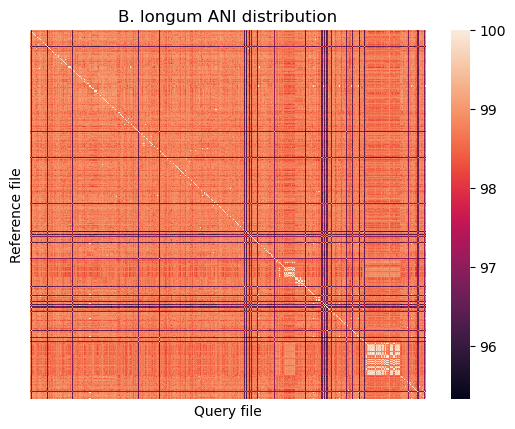

In [276]:
sns.heatmap(new_skani_matrix)
plt.xticks(ticks=[], labels=[])
plt.yticks(ticks=[], labels=[])
plt.title('B. longum ANI distribution')
plt.xlabel('Query file')
plt.ylabel('Reference file')

In [181]:
parsnp_diagonal_data = []
for sample in parsnp_sample_names:
    parsnp_diagonal_data.append({
        'p1': sample,
        'p2': sample,
        'diff': 0,
        'prc': 0,
        'ANI_1': 100,
        'ref': parsnp_mapper[sample],
        'query': parsnp_mapper[sample],
        'Tool': 'ParSNP'
    })

parsnp_diagonal_df = pd.DataFrame(parsnp_diagonal_data)
parsnp_matrix = pd.concat([parsnp_matrix, parsnp_diagonal_df], ignore_index=True)

parsnp_matrix = parsnp_matrix.sort_values(by=['p1', 'p2']).reset_index(drop=True)

parsnp_upper_triangle = parsnp_matrix.pivot_table(index='ref', columns='query', values='ANI_1').fillna(0)
parsnp_upper_triangle = parsnp_upper_triangle[sorted(parsnp_upper_triangle.columns)]

parsnp_lower_triangle = parsnp_matrix.pivot_table(index='query', columns='ref', values='ANI_1').fillna(0)
parsnp_lower_triangle = parsnp_lower_triangle[sorted(parsnp_lower_triangle.columns)]

# new_parsnp_matrix = parsnp_upper_triangle + parsnp_lower_triangle
# new_parsnp_matrix[:] = np.where(new_parsnp_matrix==200, 100, new_parsnp_matrix)

new_parsnp_matrix = np.where(parsnp_upper_triangle != 0, parsnp_upper_triangle, parsnp_lower_triangle)
# THIS PREVENTS NON-ZERO VALUES FROM BEING ADDED TOGETHER

new_parsnp_matrix = pd.DataFrame(new_parsnp_matrix, 
                                 index=parsnp_upper_triangle.index, 
                                 columns=parsnp_upper_triangle.columns)

new_parsnp_matrix

query,sample0,sample1,sample10,sample100,sample101,sample102,sample103,sample104,sample105,sample106,...,sample90,sample91,sample92,sample93,sample94,sample95,sample96,sample97,sample98,sample99
ref,,,,,,,,,,,,,,,,,,,,,
sample0,100.000000,98.245801,94.767207,82.204671,95.427160,94.226471,95.144019,94.946033,94.954548,95.126988,...,95.201499,95.365423,95.237690,95.218530,95.141890,95.586826,95.026930,83.535222,95.605986,82.200413
sample1,98.245801,100.000000,94.886424,82.368595,95.584698,94.369106,95.267494,95.056735,95.124859,95.250463,...,95.359036,95.508058,95.361165,95.361165,95.293041,95.765653,95.163179,83.720435,95.782684,82.364337
sample10,94.767207,94.886424,100.000000,82.911460,95.735848,94.477679,95.256850,95.227045,95.214272,95.386712,...,95.618760,95.299427,95.439934,95.393098,95.495285,95.733719,95.414387,84.371873,95.833777,82.907202
sample100,82.204671,82.368595,82.911460,100.000000,83.307432,83.416005,83.262725,83.143508,83.128606,83.550125,...,83.298916,83.545867,83.232921,83.090286,83.430907,83.141379,83.556511,92.410534,83.045579,99.995742
sample101,95.427160,95.584698,95.735848,83.307432,100.000000,95.344134,95.957252,95.691142,95.899772,95.972154,...,95.801844,96.110532,96.427735,96.314904,96.240393,96.738552,96.006216,84.689077,96.908863,83.303174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sample95,95.586826,95.765653,95.733719,83.141379,96.738552,95.401614,96.191429,95.816746,96.042407,96.059438,...,96.259553,96.383029,96.282971,96.338322,96.087114,100.000000,96.270198,84.571988,97.119622,83.137121
sample96,95.026930,95.163179,95.414387,83.556511,96.006216,94.971579,95.735848,95.403743,95.576182,95.833777,...,95.955123,95.703915,95.825261,95.838035,95.923190,96.270198,100.000000,84.680561,96.033892,83.552253
sample97,83.535222,83.720435,84.371873,92.410534,84.689077,84.650757,84.554957,84.565602,84.535797,85.014796,...,84.567730,84.953058,84.763588,84.471931,84.838098,84.571988,84.680561,100.000000,84.644370,92.406276


In [182]:
len(skani_sample_names), len(mummer_sample_names), len(parsnp_sample_names)

(614, 614, 614)

ENSURE SAMPLES ARE ORDERED THE SAME FOR ALL TOOLS

In [183]:
sample_name_df = pd.DataFrame({'skani': skani_sample_names,
                               'mummer': mummer_sample_names,
                               'parsnp': parsnp_sample_names})

sample_name_df

,skani,mummer,parsnp
0,GCA_008668555.1,GCA_008668555.1,GCA_008668555.1
1,GCA_008668865.1,GCA_008668865.1,GCA_008668865.1
2,GCA_008669195.1,GCA_008669195.1,GCA_008669195.1
3,GCA_008670925.1,GCA_008670925.1,GCA_008670925.1
4,GCA_008671675.1,GCA_008671675.1,GCA_008671675.1
...,...,...,...
609,flye.SQK-NBD114-96_barcode92,flye.SQK-NBD114-96_barcode92,flye.SQK-NBD114-96_barcode92
610,flye.SQK-NBD114-96_barcode93,flye.SQK-NBD114-96_barcode93,flye.SQK-NBD114-96_barcode93
611,flye.SQK-NBD114-96_barcode94,flye.SQK-NBD114-96_barcode94,flye.SQK-NBD114-96_barcode94
612,flye.SQK-NBD114-96_barcode95,flye.SQK-NBD114-96_barcode95,flye.SQK-NBD114-96_barcode95


GET LIST OF OUTLIERS

In [184]:
p = parsnp_snp_matrix.query('diff > 8000')
list_of_outliers = p['p1'].unique()
list_of_outliers

array(['GCF_003474905.1', 'GCF_004333165.1', 'GCF_002833125.1',
       'GCF_000730045.1', 'GCA_018374015.1', 'GCF_004333565.1',
       'GCF_017312605.1', 'GCF_029340215.1', 'GCF_000772485.1',
       'GCF_003466045.1', 'GCA_958426415.1', 'GCF_014334075.1',
       'GCF_003436505.1', 'GCF_016759725.1', 'GCF_000007525.1',
       'GCF_003437105.1', 'GCF_017312505.1', 'GCF_004333515.1',
       'GCF_003468825.1', 'GCF_016759805.1', 'GCF_017312625.1',
       'GCF_019731735.1', 'GCF_026236665.1', 'GCF_022643465.1',
       'GCF_004333855.1', 'GCF_015100215.1', 'GCF_000003135.1',
       'GCF_016634435.1', 'GCA_014871875.1', 'GCF_000771285.1',
       'GCF_016882605.1', 'GCF_019297795.1', 'GCF_021432165.1',
       'GCF_003475865.1', 'GCF_003370255.1', 'GCF_002833115.1',
       'GCF_017132755.1', 'GCF_004334215.1', 'GCF_004333555.1',
       'GCF_030369575.1', 'GCF_002900845.1', 'GCF_024125265.1',
       'GCF_018409165.1', 'GCA_030842885.1', 'GCF_003466545.1',
       'GCF_022643845.1', 'GCF_004332865

In [185]:
outlier_samples = [parsnp_mapper.get(sample_id, sample_id) for sample_id in list_of_outliers]
outlier_samples

# these are the blue clade on the iTOL tree

['sample210',
 'sample247',
 'sample140',
 'sample93',
 'sample28',
 'sample268',
 'sample424',
 'sample530',
 'sample101',
 'sample190',
 'sample60',
 'sample348',
 'sample165',
 'sample407',
 'sample72',
 'sample168',
 'sample419',
 'sample265',
 'sample200',
 'sample411',
 'sample425',
 'sample483',
 'sample517',
 'sample507',
 'sample282',
 'sample359',
 'sample71',
 'sample400',
 'sample15',
 'sample100',
 'sample415',
 'sample482',
 'sample496',
 'sample214',
 'sample164',
 'sample139',
 'sample416',
 'sample300',
 'sample267',
 'sample543',
 'sample151',
 'sample515',
 'sample437',
 'sample45',
 'sample194',
 'sample510',
 'sample233',
 'sample519',
 'sample137',
 'sample251',
 'sample379',
 'sample204',
 'sample53',
 'sample394',
 'sample362',
 'sample19',
 'sample97',
 'sample117',
 'sample558',
 'sample269',
 'sample389',
 'sample427',
 'sample541',
 'sample547',
 'sample13',
 'sample183',
 'sample111',
 'sample232',
 'sample198',
 'sample219',
 'sample503',
 'sample278',
 's

REMOVE OUTLIERS

In [186]:
skani_rmv_outliers = new_skani_matrix.drop(index=outlier_samples, columns=outlier_samples)
skani_rmv_outliers

query,sample10,sample102,sample103,sample105,sample106,sample107,sample108,sample109,sample11,sample112,...,sample85,sample86,sample89,sample9,sample90,sample91,sample92,sample94,sample95,sample96
ref,,,,,,,,,,,,,,,,,,,,,
sample10,100.00,98.48,98.71,98.51,98.35,98.40,98.84,98.64,98.71,98.82,...,98.52,98.62,98.49,98.58,98.49,98.72,98.59,98.46,98.56,98.26
sample102,98.48,100.00,98.64,98.70,98.79,98.58,98.83,98.75,98.81,98.78,...,98.58,98.62,98.63,98.66,98.71,98.77,98.76,98.83,98.57,98.47
sample103,98.71,98.64,100.00,98.92,98.91,98.70,99.14,98.81,99.00,99.02,...,98.71,98.84,98.97,98.96,98.98,99.02,98.86,98.60,99.08,98.48
sample105,98.51,98.70,98.92,100.00,98.71,98.66,98.86,98.51,98.90,99.02,...,98.78,98.88,98.82,98.95,98.66,99.02,98.86,98.81,98.90,98.72
sample106,98.35,98.79,98.91,98.71,100.00,98.51,98.83,98.69,98.41,98.94,...,98.53,98.86,98.88,99.01,98.95,98.98,98.84,98.89,98.95,98.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sample91,98.72,98.77,99.02,99.02,98.98,98.72,99.09,98.97,99.07,99.07,...,99.05,98.90,99.03,99.01,99.03,100.00,99.03,98.79,99.08,98.82
sample92,98.59,98.76,98.86,98.86,98.84,98.67,99.02,98.86,98.96,98.97,...,98.76,98.60,99.02,98.74,98.97,99.03,100.00,98.86,98.90,98.58
sample94,98.46,98.83,98.60,98.81,98.89,98.65,98.97,98.62,98.88,98.91,...,98.82,99.00,98.91,98.96,98.75,98.79,98.86,100.00,98.97,98.63


Text(0.5, 1.0, 'B. longum skANI without outliers')

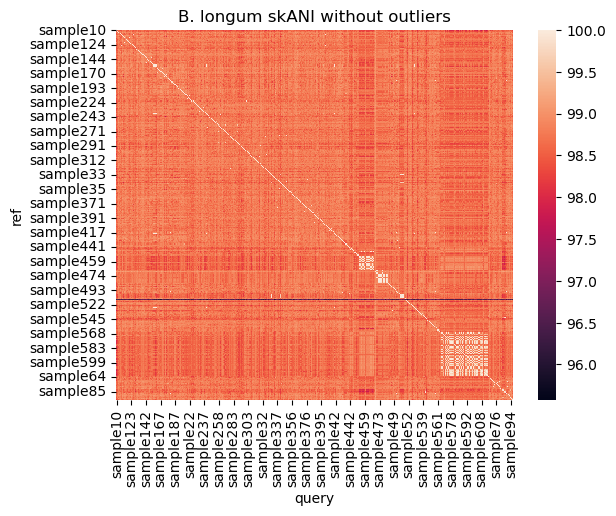

In [187]:
sns.heatmap(skani_rmv_outliers)
plt.title("B. longum skANI without outliers")

In [188]:
parsnp_snp_matrix['ref'] = parsnp_snp_matrix['p1'].map(parsnp_mapper)
parsnp_snp_matrix = parsnp_snp_matrix[~parsnp_snp_matrix['ref'].isin(outlier_samples)]
parsnp_snp_matrix

/var/folders/c4/74mrz72x32z07ktyfxzn15cw0000gn/T/ipykernel_33556/243882833.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parsnp_snp_matrix['ref'] = parsnp_snp_matrix['p1'].map(parsnp_mapper)


,p1,p2,diff,prc,ref
1839,GCF_003094935.1,GCF_004334445.1,2081,4.430205,sample154
1840,GCF_003094935.1,GCF_000730045.1,1839,3.915015,sample154
1841,GCF_003094935.1,GCA_018374015.1,6092,12.969152,sample154
1842,GCF_003094935.1,GCF_004333565.1,2221,4.728248,sample154
1843,GCF_003094935.1,GCF_019128175.1,2219,4.723990,sample154
...,...,...,...,...,...
188800,GCF_003471355.1,flye.SQK-NBD114-96_barcode75,2270,4.832563,sample203
188801,GCF_003471355.1,GCA_959018325.1,2294,4.883657,sample203
188802,GCF_004332895.1,flye.SQK-NBD114-96_barcode75,2423,5.158282,sample234
188803,GCF_004332895.1,GCA_959018325.1,2245,4.779341,sample234


Text(0.5, 1.0, '# of SNPs in all B. longum Samples - removed outliers')

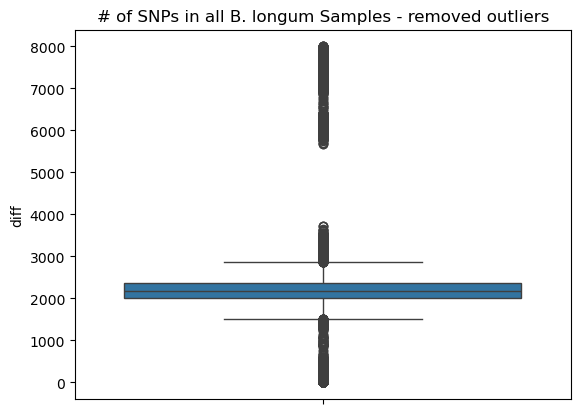

In [189]:
sns.boxplot(parsnp_snp_matrix, y='diff')
plt.title('# of SNPs in all B. longum Samples - removed outliers')

IQTREE CLUSTERS

In [190]:
# criterion = 'maxclust' cares more that the # of clusters stays the same
#             'distance' cares more that the contents of the cluster are similar

# clusters: 5
cluster min value: 92.48717348263897


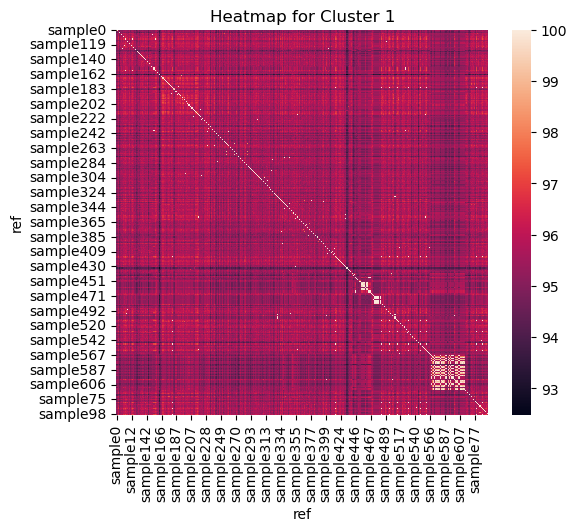

# clusters: 5
cluster min value: 100.0


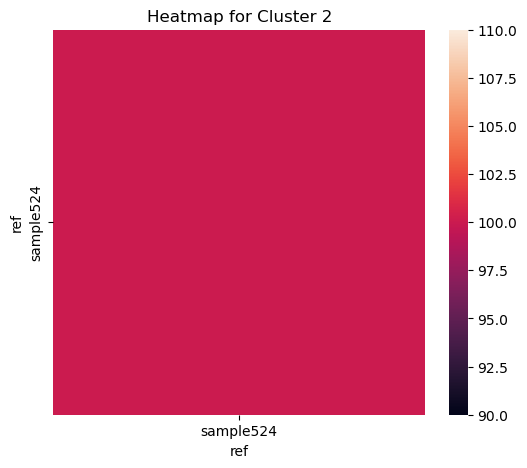

# clusters: 5
cluster min value: 96.44263725970238


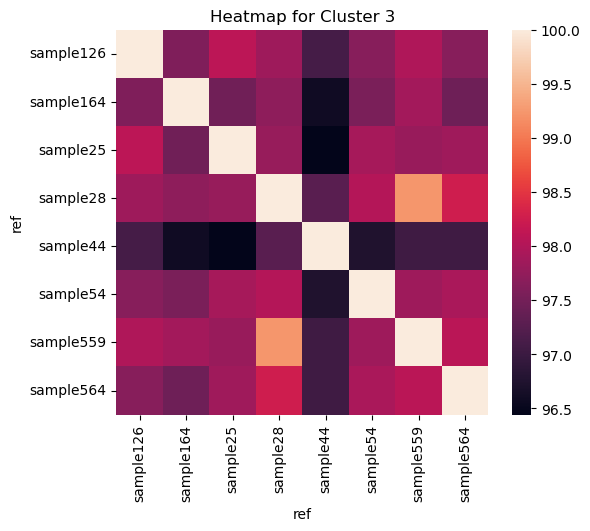

# clusters: 5
cluster min value: 99.88716922487386


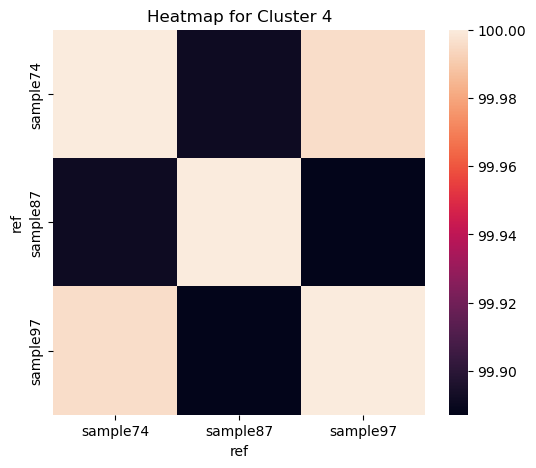

# clusters: 5
cluster min value: 92.00817490899027


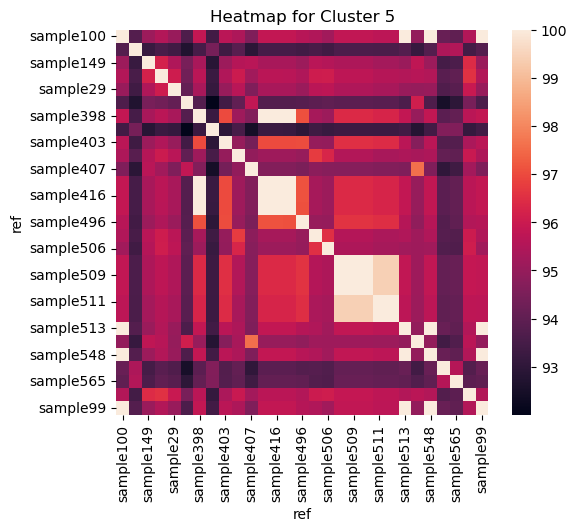

In [191]:
# try with predetermined # clusters instead of distance

new_parsnp_matrix_copy = new_parsnp_matrix.copy()
dissimilarity_matrix = 1 - new_parsnp_matrix_copy

Z = linkage(dissimilarity_matrix, method='average') # calculating branch distances, not recalculating pairwise distances?

def cluster_heatmaps(df, Z, max_clust):
    clusters = fcluster(Z, t=max_clust, criterion='maxclust') # use maxclust to preset # of clusters
    
    df['cluster'] = clusters
    
    for cluster_num in range(1, max_clust + 1):
        cluster_samples = df.index[df['cluster'] == cluster_num]
        
        submatrix = df.loc[cluster_samples, cluster_samples]
        
        print(f"# clusters: {len(df['cluster'].unique())}")
        print(f"cluster min value: {submatrix.min().min()}")

        plt.figure(figsize=(6, 5))
        sns.heatmap(submatrix, cbar=True)
        plt.title(f"Heatmap for Cluster {cluster_num}")
        plt.show()

max_dist = 5

cluster_heatmaps(new_parsnp_matrix_copy, Z, max_dist)

In [192]:
new_parsnp_matrix_copy = new_parsnp_matrix.copy()
dissimilarity_matrix = 100 - new_parsnp_matrix_copy

def cluster_heatmaps(df, max_dist):
    clustering = AgglomerativeClustering(
        metric='precomputed', # will not recalculate distances
        linkage='average', # interested to see other linkages
        distance_threshold=max_dist,
        n_clusters=None
    )
    
    clusters = clustering.fit_predict(df) # assigns samples to clusters
    
    df['cluster'] = clusters
    print(df['cluster'])
    
    unique_clusters = df['cluster'].unique()
    print(f"# clusters: {len(unique_clusters)}")

    cluster_divergence_list = []
    
    for cluster_num in unique_clusters:
        cluster_samples = df.index[df['cluster'] == cluster_num]
        submatrix = df.loc[cluster_samples, cluster_samples]
        
        max_divergence = submatrix.max().max()
        print(f"cluster {cluster_num} max divergence: {max_divergence}")
        
        cluster_divergence_list.append({'cluster': cluster_num, 'max_divergence': max_divergence})

        # print(f"cluster min value: {submatrix.min().min()}")

        # plt.figure(figsize=(6, 5))
        # sns.heatmap(submatrix, cbar=True)
        # plt.title(f"Heatmap for Cluster {cluster_num}")
        # plt.show()
    
    divergence_df = pd.DataFrame(cluster_divergence_list)
    
    return df, divergence_df
        
        # plt.figure(figsize=(6, 5))
        # sns.heatmap(submatrix, cbar=True)
        # plt.title(f"Heatmap for Cluster {cluster_num + 1}")
        # plt.show()

max_dist = 3

dissimilarity_matrix_clusters, max_divergence_df = cluster_heatmaps(dissimilarity_matrix, max_dist)

ref
sample0       17
sample1       17
sample10     223
sample100    137
sample101    375
            ... 
sample95     188
sample96     109
sample97      63
sample98      39
sample99     137
Name: cluster, Length: 614, dtype: int64
# clusters: 382
cluster 17 max divergence: 1.7541992208289798
cluster 223 max divergence: 0.0
cluster 137 max divergence: 0.00851553019819562
cluster 375 max divergence: 0.0
cluster 303 max divergence: 0.0
cluster 2 max divergence: 2.6355565963425818
cluster 195 max divergence: 0.0
cluster 124 max divergence: 0.0
cluster 296 max divergence: 0.0
cluster 177 max divergence: 0.00425776509909781
cluster 340 max divergence: 0.0
cluster 359 max divergence: 0.0
cluster 54 max divergence: 0.01915994294594725
cluster 39 max divergence: 2.754774019117363
cluster 82 max divergence: 0.17456836906308126
cluster 267 max divergence: 0.0
cluster 126 max divergence: 0.0
cluster 275 max divergence: 0.0
cluster 326 max divergence: 0.0
cluster 344 max divergence: 0.0
cluster 29

In [193]:
dissimilarity_matrix_clusters

query,sample0,sample1,sample10,sample100,sample101,sample102,sample103,sample104,sample105,sample106,...,sample91,sample92,sample93,sample94,sample95,sample96,sample97,sample98,sample99,cluster
ref,,,,,,,,,,,,,,,,,,,,,
sample0,0.000000,1.754199,5.232793,17.795329,4.572840,5.773529,4.855981,5.053967,5.045452,4.873012,...,4.634577,4.762310,4.781470,4.858110,4.413174,4.973070,16.464778,4.394014,17.799587,17
sample1,1.754199,0.000000,5.113576,17.631405,4.415302,5.630894,4.732506,4.943265,4.875141,4.749537,...,4.491942,4.638835,4.638835,4.706959,4.234347,4.836821,16.279565,4.217316,17.635663,17
sample10,5.232793,5.113576,0.000000,17.088540,4.264152,5.522321,4.743150,4.772955,4.785728,4.613288,...,4.700573,4.560066,4.606902,4.504715,4.266281,4.585613,15.628127,4.166223,17.092798,223
sample100,17.795329,17.631405,17.088540,0.000000,16.692568,16.583995,16.737275,16.856492,16.871394,16.449875,...,16.454133,16.767079,16.909714,16.569093,16.858621,16.443489,7.589466,16.954421,0.004258,137
sample101,4.572840,4.415302,4.264152,16.692568,0.000000,4.655866,4.042748,4.308858,4.100228,4.027846,...,3.889468,3.572265,3.685096,3.759607,3.261448,3.993784,15.310923,3.091137,16.696826,375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sample95,4.413174,4.234347,4.266281,16.858621,3.261448,4.598386,3.808571,4.183254,3.957593,3.940562,...,3.616971,3.717029,3.661678,3.912886,0.000000,3.729802,15.428012,2.880378,16.862879,188
sample96,4.973070,4.836821,4.585613,16.443489,3.993784,5.028421,4.264152,4.596257,4.423818,4.166223,...,4.296085,4.174739,4.161965,4.076810,3.729802,0.000000,15.319439,3.966108,16.447747,109
sample97,16.464778,16.279565,15.628127,7.589466,15.310923,15.349243,15.445043,15.434398,15.464203,14.985204,...,15.046942,15.236412,15.528069,15.161902,15.428012,15.319439,0.000000,15.355630,7.593724,63


In [194]:
max_divergence_df

,cluster,max_divergence
0,17,1.754199
1,223,0.000000
2,137,0.008516
3,375,0.000000
4,303,0.000000
...,...,...
377,169,0.000000
378,73,0.000000
379,153,0.000000
380,188,0.000000


In [195]:
max_divergence_df.query('max_divergence == 0')

# 300 singleton clusters

,cluster,max_divergence
1,223,0.0
3,375,0.0
4,303,0.0
6,195,0.0
7,124,0.0
...,...,...
377,169,0.0
378,73,0.0
379,153,0.0
380,188,0.0


In [196]:
to_merge = dissimilarity_matrix['cluster'].reset_index()
to_merge

,ref,cluster
0,sample0,17
1,sample1,17
2,sample10,223
3,sample100,137
4,sample101,375
...,...,...
609,sample95,188
610,sample96,109
611,sample97,63
612,sample98,39


In [197]:
to_merge['cluster'].unique()

array([ 17, 223, 137, 375, 303,   2, 195, 124, 296, 177, 340, 359,  54,
        39,  82, 267, 126, 275, 326, 344, 293, 268, 370, 319, 306, 295,
        21, 261, 367, 201, 239,   4, 337, 237, 330, 192, 335,  72, 202,
       286, 361, 300, 238,  36,   1, 247, 320, 314, 263, 224, 253, 178,
       328, 159, 309,  26, 221, 248, 227, 207,  12, 297, 357, 377, 125,
       270, 283,   9, 246,  50, 142,  14, 291,  97, 133, 140,  20, 343,
         7,  45, 366,  68, 321, 186, 365,  56, 266,  49, 288, 376,  10,
       364, 184, 371,  27, 313,  51, 212, 215, 284, 233, 347, 304, 249,
        93,  31,  11, 329, 287, 156, 305, 262, 234, 199, 235, 311,  47,
       362, 269, 342, 225,  18, 243, 203, 279, 271,   6, 379,  91, 118,
       310, 193, 130, 231, 381, 217, 331, 226, 164, 372, 301, 116, 216,
       219, 138, 322, 356,  13, 264, 299, 351, 232, 317, 312, 292, 245,
       265,  70, 324, 336, 315, 380,  30, 282, 348, 155, 327, 360, 332,
       260,  35, 349,  48, 204,  94, 369, 316, 240, 241, 197, 11

In [198]:
merged_parsnp = pd.merge(parsnp_matrix, to_merge, on='ref', how='left')
iqtree_parsnp = merged_parsnp[['p1', 'cluster']].drop_duplicates().reset_index().drop('index', axis=1)

unique_clusters = iqtree_parsnp['cluster'].unique()
palette = sns.color_palette(None, len(unique_clusters))

cluster_color_map = {cluster: f'rgba({color[0]*255:.2f},{color[1]*255:.2f},{color[2]*255:.2f},1.0)' 
                     for cluster, color in zip(unique_clusters, palette)}

iqtree_parsnp['colour'] = iqtree_parsnp['cluster'].map(cluster_color_map)
iqtree_parsnp

,p1,cluster,colour
0,GCA_008668555.1,17,"rgba(31.00,119.00,180.00,1.0)"
1,GCA_008668865.1,17,"rgba(31.00,119.00,180.00,1.0)"
2,GCA_008669195.1,68,"rgba(255.00,127.00,14.00,1.0)"
3,GCA_008670925.1,68,"rgba(255.00,127.00,14.00,1.0)"
4,GCA_008671675.1,90,"rgba(44.00,160.00,44.00,1.0)"
...,...,...,...
609,flye.SQK-NBD114-96_barcode92,43,"rgba(255.00,127.00,14.00,1.0)"
610,flye.SQK-NBD114-96_barcode93,43,"rgba(255.00,127.00,14.00,1.0)"
611,flye.SQK-NBD114-96_barcode94,43,"rgba(255.00,127.00,14.00,1.0)"
612,flye.SQK-NBD114-96_barcode95,43,"rgba(255.00,127.00,14.00,1.0)"


In [199]:
max_divergence_df.query('cluster == 43'), max_divergence_df.query('cluster == 25')

(     cluster  max_divergence
 352       43        2.403508,
      cluster  max_divergence
 351       25        0.498159)

In [ ]:
with open('/home/ubuntu/wdir/PopGenStats_Project/data/B_longum/tree/iqtree.parsnp.renamed.treefile.annot.ahc_dist.txt', 'w') as f:
    f.write("\n")
    f.write("        DATASET_COLORSTRIP\n\n")
    f.write("        SEPARATOR SPACE\n")
    f.write("        DATASET_LABEL ahc_dist\n")
    f.write("        COLOR #ff0000\n\n")
    f.write("        COLOR_BRANCHES 0\n\n")
    f.write("        DATA\n\n")
    
    for _, row in iqtree_parsnp.iterrows():
        genome_id = row['p1']
        colour = row['colour']
        cluster = row['cluster']
        f.write(f"{genome_id} {colour} {cluster}\n")

In [201]:
parsnp_snp_matrix

,p1,p2,diff,prc,ref
1839,GCF_003094935.1,GCF_004334445.1,2081,4.430205,sample154
1840,GCF_003094935.1,GCF_000730045.1,1839,3.915015,sample154
1841,GCF_003094935.1,GCA_018374015.1,6092,12.969152,sample154
1842,GCF_003094935.1,GCF_004333565.1,2221,4.728248,sample154
1843,GCF_003094935.1,GCF_019128175.1,2219,4.723990,sample154
...,...,...,...,...,...
188800,GCF_003471355.1,flye.SQK-NBD114-96_barcode75,2270,4.832563,sample203
188801,GCF_003471355.1,GCA_959018325.1,2294,4.883657,sample203
188802,GCF_004332895.1,flye.SQK-NBD114-96_barcode75,2423,5.158282,sample234
188803,GCF_004332895.1,GCA_959018325.1,2245,4.779341,sample234


In [202]:
m = iqtree_parsnp.merge(parsnp_snp_matrix)
m

,p1,cluster,colour,p2,diff,prc,ref
0,GCA_008672355.1,83,"rgba(214.00,39.00,40.00,1.0)",GCF_017312525.1,2289,4.873012,sample7
1,GCA_008672355.1,83,"rgba(214.00,39.00,40.00,1.0)",GCF_003475055.1,2054,4.372725,sample7
2,GCA_008672355.1,83,"rgba(214.00,39.00,40.00,1.0)",GCA_030842385.1,5960,12.688140,sample7
3,GCA_008672355.1,83,"rgba(214.00,39.00,40.00,1.0)",GCF_009896525.1,1888,4.019330,sample7
4,GCA_008672355.1,83,"rgba(214.00,39.00,40.00,1.0)",GCF_003473205.1,2016,4.291827,sample7
...,...,...,...,...,...,...,...
120779,flye.SQK-NBD114-96_barcode96,43,"rgba(255.00,127.00,14.00,1.0)",GCF_003464805.1,1978,4.210930,sample613
120780,flye.SQK-NBD114-96_barcode96,43,"rgba(255.00,127.00,14.00,1.0)",GCF_003471355.1,1854,3.946948,sample613
120781,flye.SQK-NBD114-96_barcode96,43,"rgba(255.00,127.00,14.00,1.0)",GCF_004332895.1,2127,4.528133,sample613
120782,flye.SQK-NBD114-96_barcode96,43,"rgba(255.00,127.00,14.00,1.0)",flye.SQK-NBD114-96_barcode75,2045,4.353565,sample613


In [203]:
n = m.query('diff > 2750')
to_remove = n['cluster'].unique()
to_remove

array([ 83, 223,  54, 361,  26, 142, 321,  49,  93, 164, 327, 316, 211,
        41, 205, 378, 252, 244, 280, 101, 214, 307, 106, 180, 281, 272,
       168, 166, 294,  98,  71, 339, 161, 157,  75, 170,  67, 129,  61,
        78,   9, 120,  58, 210, 119,  88,  33,  39, 169,  73,  10, 109,
       303,   2, 124, 296, 177, 340, 359,  82, 275, 326, 293, 268, 370,
       306, 295, 261, 367, 201,   4, 337, 237, 330, 192, 335,  72, 238,
        36,   1, 247, 320, 314, 253, 178, 221, 297, 357, 125, 270, 246,
        14, 291,  97, 133, 140,  20, 343,  45, 365,  56, 376, 313,  51,
       212, 215, 284, 233, 347, 304, 249,  31,  11, 305, 262, 234, 199,
       311,  47, 269, 243, 203, 271,   6, 379,  91, 118, 193, 130, 231,
       301, 116, 216, 219, 138,  13, 264, 299, 351, 232, 317, 312, 292,
       245,  70, 324, 336, 315, 380, 282, 332, 260, 349,  48, 204,  94,
       369, 240,  35, 241, 197, 115, 134, 318,  30, 122, 255, 111, 179,
       131, 151, 353, 236, 374,   5,  59, 198, 354,  24, 222, 21

In [204]:
len(to_remove)

277

MAKE COLOUR RING FOR ITOL TREE TO HIGHLIGHT OUTLIERS

In [205]:
outlier_colour = 'rgba(255.00,0.00,0.00,1.0)'
default_colour = 'rgba(200.00,200.00,200.00,1.0)'

def assign_colour(cluster):
    if cluster in to_remove:
        return outlier_colour
    else:
        return default_colour

m['new_colour'] = m['cluster'].apply(assign_colour)
m

,p1,cluster,colour,p2,diff,prc,ref,new_colour
0,GCA_008672355.1,83,"rgba(214.00,39.00,40.00,1.0)",GCF_017312525.1,2289,4.873012,sample7,"rgba(255.00,0.00,0.00,1.0)"
1,GCA_008672355.1,83,"rgba(214.00,39.00,40.00,1.0)",GCF_003475055.1,2054,4.372725,sample7,"rgba(255.00,0.00,0.00,1.0)"
2,GCA_008672355.1,83,"rgba(214.00,39.00,40.00,1.0)",GCA_030842385.1,5960,12.688140,sample7,"rgba(255.00,0.00,0.00,1.0)"
3,GCA_008672355.1,83,"rgba(214.00,39.00,40.00,1.0)",GCF_009896525.1,1888,4.019330,sample7,"rgba(255.00,0.00,0.00,1.0)"
4,GCA_008672355.1,83,"rgba(214.00,39.00,40.00,1.0)",GCF_003473205.1,2016,4.291827,sample7,"rgba(255.00,0.00,0.00,1.0)"
...,...,...,...,...,...,...,...,...
120779,flye.SQK-NBD114-96_barcode96,43,"rgba(255.00,127.00,14.00,1.0)",GCF_003464805.1,1978,4.210930,sample613,"rgba(255.00,0.00,0.00,1.0)"
120780,flye.SQK-NBD114-96_barcode96,43,"rgba(255.00,127.00,14.00,1.0)",GCF_003471355.1,1854,3.946948,sample613,"rgba(255.00,0.00,0.00,1.0)"
120781,flye.SQK-NBD114-96_barcode96,43,"rgba(255.00,127.00,14.00,1.0)",GCF_004332895.1,2127,4.528133,sample613,"rgba(255.00,0.00,0.00,1.0)"
120782,flye.SQK-NBD114-96_barcode96,43,"rgba(255.00,127.00,14.00,1.0)",flye.SQK-NBD114-96_barcode75,2045,4.353565,sample613,"rgba(255.00,0.00,0.00,1.0)"


In [ ]:
with open('/home/ubuntu/wdir/PopGenStats_Project/data/B_longum/tree/iqtree.parsnp.renamed.treefile.annot.ahc_remove_blue.txt', 'w') as f:
    f.write("\n")
    f.write("        DATASET_COLORSTRIP\n\n")
    f.write("        SEPARATOR SPACE\n")
    f.write("        DATASET_LABEL ahc_remove_blue\n")
    f.write("        COLOR #ff0000\n\n")
    f.write("        COLOR_BRANCHES 0\n\n")
    f.write("        DATA\n\n")
    
    for _, row in m.iterrows():
        genome_id = row['p1']
        colour = row['new_colour']
        cluster = row['cluster']
        f.write(f"{genome_id} {colour} {cluster}\n")

In [207]:
# Gap in colour ring on iTOL tree -
# does GCA 959018325.1 have a cluster?

m.query("p1 == 'GCA_959018325.1'")

,p1,cluster,colour,p2,diff,prc,ref,new_colour


In [208]:
m_filtered = m[~m['cluster'].isin(to_remove)]
m_filtered

,p1,cluster,colour,p2,diff,prc,ref,new_colour
9091,GCA_958414505.1,278,"rgba(44.00,160.00,44.00,1.0)",GCF_000730105.1,1708,3.636131,sample57,"rgba(200.00,200.00,200.00,1.0)"
9092,GCA_958414505.1,278,"rgba(44.00,160.00,44.00,1.0)",GCF_003464805.1,1621,3.450919,sample57,"rgba(200.00,200.00,200.00,1.0)"
9093,GCA_958414505.1,278,"rgba(44.00,160.00,44.00,1.0)",GCF_003471355.1,2006,4.270538,sample57,"rgba(200.00,200.00,200.00,1.0)"
9094,GCA_958414505.1,278,"rgba(44.00,160.00,44.00,1.0)",GCF_004332895.1,1898,4.040619,sample57,"rgba(200.00,200.00,200.00,1.0)"
9095,GCA_958414505.1,278,"rgba(44.00,160.00,44.00,1.0)",flye.SQK-NBD114-96_barcode75,2434,5.181700,sample57,"rgba(200.00,200.00,200.00,1.0)"
9096,GCA_958414505.1,278,"rgba(44.00,160.00,44.00,1.0)",GCA_959018325.1,2236,4.760181,sample57,"rgba(200.00,200.00,200.00,1.0)"
17383,GCF_000730105.1,188,"rgba(44.00,160.00,44.00,1.0)",GCF_003464805.1,1356,2.886765,sample95,"rgba(200.00,200.00,200.00,1.0)"
17384,GCF_000730105.1,188,"rgba(44.00,160.00,44.00,1.0)",GCF_003471355.1,1730,3.682967,sample95,"rgba(200.00,200.00,200.00,1.0)"
17385,GCF_000730105.1,188,"rgba(44.00,160.00,44.00,1.0)",GCF_004332895.1,1784,3.797926,sample95,"rgba(200.00,200.00,200.00,1.0)"
17386,GCF_000730105.1,188,"rgba(44.00,160.00,44.00,1.0)",flye.SQK-NBD114-96_barcode75,2316,4.930492,sample95,"rgba(200.00,200.00,200.00,1.0)"


In [210]:
cluster_stats = m.groupby('cluster')['diff'].agg(['mean', 'median'])
cluster_stats

,mean,median
cluster,,
0,2163.352041,1870.0
1,2359.710037,2017.5
2,2390.125714,2073.5
4,2189.393939,1887.0
5,2421.148211,2100.0
...,...,...
374,2461.396175,2140.5
376,2566.873479,2251.0
378,2539.840445,2213.0


<Axes: >

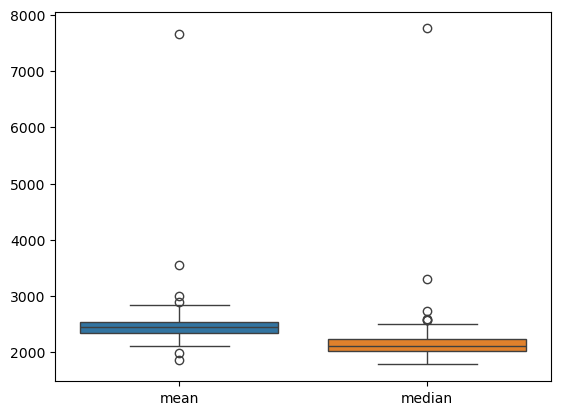

In [ ]:
sns.boxplot(cluster_stats)

GET # SNPS FOR GREEN AND YELLOW CLADES

In [212]:
# from ahc_dist:
# green = cluster 25
# yellow = cluster 43

In [213]:
m

,p1,cluster,colour,p2,diff,prc,ref,new_colour
0,GCA_008672355.1,83,"rgba(214.00,39.00,40.00,1.0)",GCF_017312525.1,2289,4.873012,sample7,"rgba(255.00,0.00,0.00,1.0)"
1,GCA_008672355.1,83,"rgba(214.00,39.00,40.00,1.0)",GCF_003475055.1,2054,4.372725,sample7,"rgba(255.00,0.00,0.00,1.0)"
2,GCA_008672355.1,83,"rgba(214.00,39.00,40.00,1.0)",GCA_030842385.1,5960,12.688140,sample7,"rgba(255.00,0.00,0.00,1.0)"
3,GCA_008672355.1,83,"rgba(214.00,39.00,40.00,1.0)",GCF_009896525.1,1888,4.019330,sample7,"rgba(255.00,0.00,0.00,1.0)"
4,GCA_008672355.1,83,"rgba(214.00,39.00,40.00,1.0)",GCF_003473205.1,2016,4.291827,sample7,"rgba(255.00,0.00,0.00,1.0)"
...,...,...,...,...,...,...,...,...
120779,flye.SQK-NBD114-96_barcode96,43,"rgba(255.00,127.00,14.00,1.0)",GCF_003464805.1,1978,4.210930,sample613,"rgba(255.00,0.00,0.00,1.0)"
120780,flye.SQK-NBD114-96_barcode96,43,"rgba(255.00,127.00,14.00,1.0)",GCF_003471355.1,1854,3.946948,sample613,"rgba(255.00,0.00,0.00,1.0)"
120781,flye.SQK-NBD114-96_barcode96,43,"rgba(255.00,127.00,14.00,1.0)",GCF_004332895.1,2127,4.528133,sample613,"rgba(255.00,0.00,0.00,1.0)"
120782,flye.SQK-NBD114-96_barcode96,43,"rgba(255.00,127.00,14.00,1.0)",flye.SQK-NBD114-96_barcode75,2045,4.353565,sample613,"rgba(255.00,0.00,0.00,1.0)"


In [214]:
m_yellow = m.query('cluster == 43')
m_yellow

,p1,cluster,colour,p2,diff,prc,ref,new_colour
107104,flye.SQK-NBD114-96_barcode51,43,"rgba(255.00,127.00,14.00,1.0)",GCF_005406285.1,2181,4.643093,sample569,"rgba(255.00,0.00,0.00,1.0)"
107105,flye.SQK-NBD114-96_barcode51,43,"rgba(255.00,127.00,14.00,1.0)",GCF_022014335.1,1960,4.172610,sample569,"rgba(255.00,0.00,0.00,1.0)"
107106,flye.SQK-NBD114-96_barcode51,43,"rgba(255.00,127.00,14.00,1.0)",GCF_004333035.1,2102,4.474911,sample569,"rgba(255.00,0.00,0.00,1.0)"
107107,flye.SQK-NBD114-96_barcode51,43,"rgba(255.00,127.00,14.00,1.0)",GCF_019131855.1,2316,4.930492,sample569,"rgba(255.00,0.00,0.00,1.0)"
107108,flye.SQK-NBD114-96_barcode51,43,"rgba(255.00,127.00,14.00,1.0)",GCA_019419305.1,2092,4.453622,sample569,"rgba(255.00,0.00,0.00,1.0)"
...,...,...,...,...,...,...,...,...
120779,flye.SQK-NBD114-96_barcode96,43,"rgba(255.00,127.00,14.00,1.0)",GCF_003464805.1,1978,4.210930,sample613,"rgba(255.00,0.00,0.00,1.0)"
120780,flye.SQK-NBD114-96_barcode96,43,"rgba(255.00,127.00,14.00,1.0)",GCF_003471355.1,1854,3.946948,sample613,"rgba(255.00,0.00,0.00,1.0)"
120781,flye.SQK-NBD114-96_barcode96,43,"rgba(255.00,127.00,14.00,1.0)",GCF_004332895.1,2127,4.528133,sample613,"rgba(255.00,0.00,0.00,1.0)"
120782,flye.SQK-NBD114-96_barcode96,43,"rgba(255.00,127.00,14.00,1.0)",flye.SQK-NBD114-96_barcode75,2045,4.353565,sample613,"rgba(255.00,0.00,0.00,1.0)"


In [215]:
m_yellow['p1'].to_list

<bound method IndexOpsMixin.tolist of 107104    flye.SQK-NBD114-96_barcode51
107105    flye.SQK-NBD114-96_barcode51
107106    flye.SQK-NBD114-96_barcode51
107107    flye.SQK-NBD114-96_barcode51
107108    flye.SQK-NBD114-96_barcode51
                      ...             
120779    flye.SQK-NBD114-96_barcode96
120780    flye.SQK-NBD114-96_barcode96
120781    flye.SQK-NBD114-96_barcode96
120782    flye.SQK-NBD114-96_barcode96
120783    flye.SQK-NBD114-96_barcode96
Name: p1, Length: 9661, dtype: object>

In [216]:
len(m_yellow)

9661

Text(0.5, 1.0, 'SNP distribution for B. longum Yellow Clade')

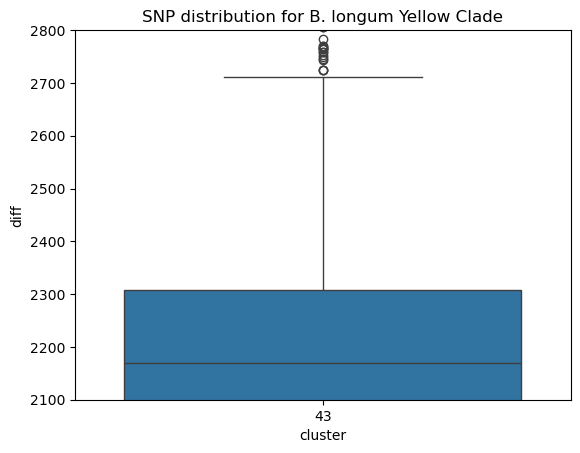

In [217]:
sns.boxplot(m_yellow, x='cluster', y='diff')
plt.ylim(2100, 2800)
plt.title("SNP distribution for B. longum Yellow Clade")

In [218]:
m_green = m.query('cluster == 25')
m_green

,p1,cluster,colour,p2,diff,prc,ref,new_colour
106804,flye.SQK-NBD114-96_barcode49,25,"rgba(31.00,119.00,180.00,1.0)",GCF_019131725.1,2568,5.466970,sample567,"rgba(255.00,0.00,0.00,1.0)"
106805,flye.SQK-NBD114-96_barcode49,25,"rgba(31.00,119.00,180.00,1.0)",GCF_014898115.1,2205,4.694186,sample567,"rgba(255.00,0.00,0.00,1.0)"
106806,flye.SQK-NBD114-96_barcode49,25,"rgba(31.00,119.00,180.00,1.0)",GCF_021184065.1,2169,4.617546,sample567,"rgba(255.00,0.00,0.00,1.0)"
106807,flye.SQK-NBD114-96_barcode49,25,"rgba(31.00,119.00,180.00,1.0)",GCA_022713085.1,2426,5.164669,sample567,"rgba(255.00,0.00,0.00,1.0)"
106808,flye.SQK-NBD114-96_barcode49,25,"rgba(31.00,119.00,180.00,1.0)",GCF_028894815.1,2392,5.092287,sample567,"rgba(255.00,0.00,0.00,1.0)"
...,...,...,...,...,...,...,...,...
119050,flye.SQK-NBD114-96_barcode89,25,"rgba(31.00,119.00,180.00,1.0)",GCF_003464805.1,2177,4.634577,sample606,"rgba(255.00,0.00,0.00,1.0)"
119051,flye.SQK-NBD114-96_barcode89,25,"rgba(31.00,119.00,180.00,1.0)",GCF_003471355.1,2249,4.787857,sample606,"rgba(255.00,0.00,0.00,1.0)"
119052,flye.SQK-NBD114-96_barcode89,25,"rgba(31.00,119.00,180.00,1.0)",GCF_004332895.1,2410,5.130607,sample606,"rgba(255.00,0.00,0.00,1.0)"
119053,flye.SQK-NBD114-96_barcode89,25,"rgba(31.00,119.00,180.00,1.0)",flye.SQK-NBD114-96_barcode75,83,0.176697,sample606,"rgba(255.00,0.00,0.00,1.0)"


In [219]:
len(m_green)

4319

Text(0.5, 1.0, 'SNP distribution for B. longum Green Clade')

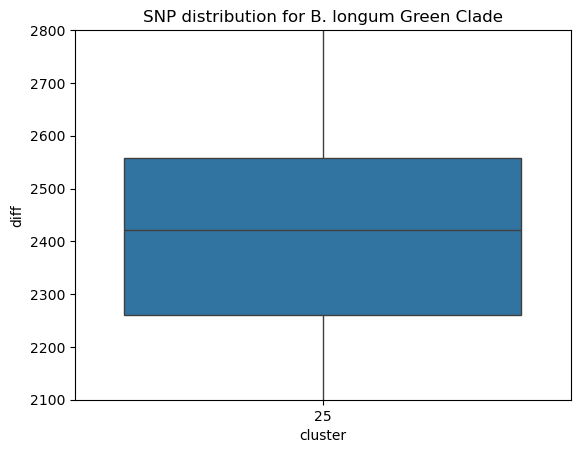

In [220]:
sns.boxplot(m_green, x='cluster', y='diff')
plt.ylim(2100, 2800)
plt.title("SNP distribution for B. longum Green Clade")

CLUSTERING FUNCTIONS

In [221]:
def get_clustered_matrix(distance_matrix, cluster_function, threshold, criterion, kwargs={}):
    
    a = np.array(distance_matrix)
    a = a[np.triu_indices_from(a, k=1)]
    
    try:
        clustering = cluster_function(a, metric=None, ** kwargs)
    except TypeError:
        clustering = cluster_function(a, ** kwargs)

    d = dict(zip(distance_matrix.index, fcluster(clustering, threshold, criterion)))
    order = sorted(d, key=lambda n: d.get(n))
    
    nframe = distance_matrix.copy()
    nframe = nframe[order]
    return nframe.reindex(order), d

def get_clusters_stats(res):
    matrix, clustering = res
    nclusters = len(set(clustering.values()))

    matrix = matrix.melt(ignore_index=False, value_name='distance').reset_index()
    matrix['ss1c'] = matrix['ref'].apply(lambda key: clustering[key])
    matrix['ss2c'] = matrix['query'].apply(lambda key: clustering[key])

    smatrix = matrix[matrix['ref'] != matrix['query']]
    same_smatrix = smatrix[smatrix['ss1c'] == smatrix['ss2c']]
    intra_sim = same_smatrix.groupby('ss1c')['distance'].describe().reset_index()

    notsame_smatrix = smatrix[smatrix['ss1c'] != smatrix['ss2c']]
    inter_sim = notsame_smatrix.groupby(['ss1c', 'ss2c'])['distance'].describe().reset_index()

    return nclusters, intra_sim, inter_sim


In [222]:
# matrices = {
#     'mummer': new_mummer_matrix,
#     'skani': new_skani_matrix,
#     'parsnp': new_parsnp_matrix
# }

# d = {
#     'single_distance_1': (single, 1, 'distance', {}),
#     'complete_distance_1': (complete, 1, 'distance', {}),
#     'avg_distance_1': (average, 1, 'distance', {}),
#     'single_distance_96': (single, 96.5, 'distance', {}),
#     'avg_distance_98': (average, 98.5, 'distance', {})
#     # 'avg_distance_50': (average, 50, 'distance', {}),
#     # 'avg_distance_75': (average, 75, 'distance', {}),
#     # 'avg_distance_80': (average, 80, 'distance', {}),
#     # 'avg_distance_85': (average, 85, 'distance', {})
#     # 'linkage_complete_distance_10': (linkage, 10, 'distance', {'method': 'complete'}),
#     # 'linkage_complete_distance_15': (linkage, 15, 'distance', {'method': 'complete'}),
#     # 'linkage_complete_distance_20': (linkage, 20, 'distance', {'method': 'complete'}),
#     # 'linkage_complete_distance_25': (linkage, 25, 'distance', {'method': 'complete'})
# }

# allres_ncluster = []
# allres_intra = []
# allres_inter = []

# for matrix_name, matrix in matrices.items():
#     for method_name, values in d.items():
#         res = get_clustered_matrix(matrix, *values)
#         stats = get_clusters_stats(res)
#         ncluster, intra, inter = stats
        
#         ncluster = len(set(res[1].values()))
#         allres_ncluster.append({
#             'method': method_name,
#             'nclusters': ncluster,
#             'matrix': matrix_name
#         })

#         intra['method'] = method_name
#         intra['matrix'] = matrix_name
#         allres_intra.append(intra)
        
#         inter['method'] = method_name
#         inter['matrix'] = matrix_name
#         allres_inter.append(inter)

#         colors = list(sns.color_palette())
#         colors = [colors[value % len(colors)] for value in sorted(res[1].values())]

#         sns.clustermap(res[0], row_cluster=False, col_cluster=False, row_colors=colors, col_colors=colors)
#         plt.title(method_name)
    
# allres_ncluster = pd.DataFrame(allres_ncluster)
# allres_inter = pd.concat(allres_inter)
# allres_intra = pd.concat(allres_intra)

# allres_intra['max'].max(), allres_inter['min'].min()

In [223]:
# allres_intra.describe()

COMPUTE DISTANCE MATRICES

In [224]:
skani_dist_matrix = 100 - new_skani_matrix
mummer_dist_matrix = 100 - new_mummer_matrix
parsnp_dist_matrix = 100 - new_parsnp_matrix

In [225]:
if (mummer_dist_matrix < 0).any().any():
    raise ValueError("MUMmer distance matrix contains negative values")
if (skani_dist_matrix < 0).any().any():
    raise ValueError("skANI distance matrix contains negative values")
if (parsnp_dist_matrix < 0).any().any():
    raise ValueError("ParSNP distance matrix contains negative values")

THRESHOLD VS # CLUSTERS

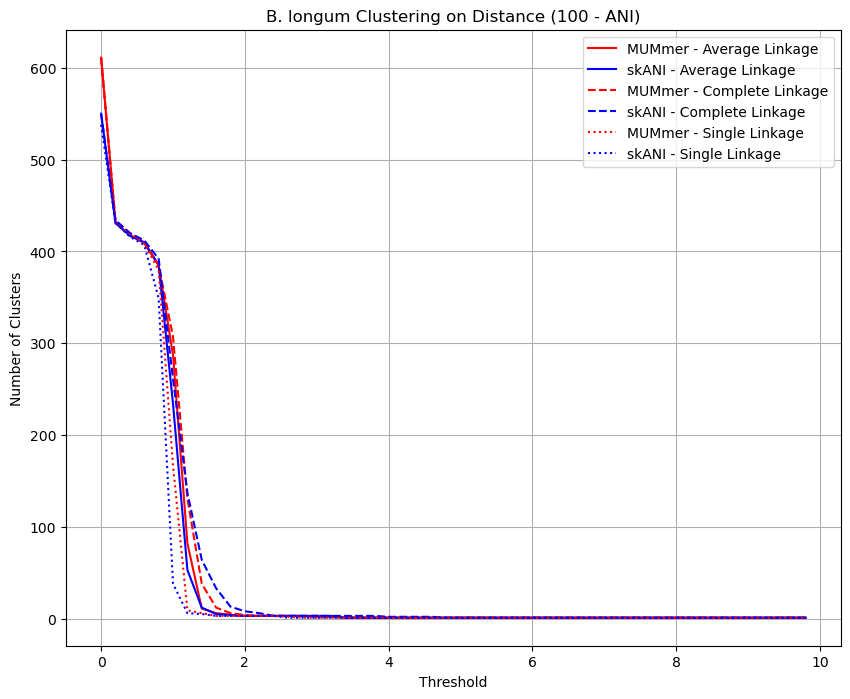

In [226]:
threshold_values = [i / 10 for i in range(0, 100, 2)]

mummer_results_avg, skani_results_avg = {}, {}
mummer_results_compl, skani_results_compl = {}, {}
mummer_results_single, skani_results_single = {}, {}

for threshold in threshold_values:
    # average
    mummer_res_a = get_clustered_matrix(mummer_dist_matrix, average, threshold, 'distance')
    skani_res_a = get_clustered_matrix(skani_dist_matrix, average, threshold, 'distance')

    mummer_clusters_a = mummer_res_a[1]
    skani_clusters_a = skani_res_a[1]

    num_mummer_clusters_a = len(set(mummer_clusters_a.values()))
    num_skani_clusters_a = len(set(skani_clusters_a.values()))

    mummer_results_avg[threshold] = num_mummer_clusters_a
    skani_results_avg[threshold] = num_skani_clusters_a

    # complete
    mummer_res_c = get_clustered_matrix(mummer_dist_matrix, complete, threshold, 'distance')
    skani_res_c = get_clustered_matrix(skani_dist_matrix, complete, threshold, 'distance')

    mummer_clusters_c = mummer_res_c[1]
    skani_clusters_c = skani_res_c[1]

    num_mummer_clusters_c = len(set(mummer_clusters_c.values()))
    num_skani_clusters_c = len(set(skani_clusters_c.values()))

    mummer_results_compl[threshold] = num_mummer_clusters_c
    skani_results_compl[threshold] = num_skani_clusters_c

    # single
    mummer_res_s = get_clustered_matrix(mummer_dist_matrix, single, threshold, 'distance')
    skani_res_s = get_clustered_matrix(skani_dist_matrix, single, threshold, 'distance')

    mummer_clusters_s = mummer_res_s[1]
    skani_clusters_s = skani_res_s[1]

    num_mummer_clusters_s = len(set(mummer_clusters_s.values()))
    num_skani_clusters_s = len(set(skani_clusters_s.values()))

    mummer_results_single[threshold] = num_mummer_clusters_s
    skani_results_single[threshold] = num_skani_clusters_s

plt.figure(figsize=(10, 8))

plt.plot(list(mummer_results_avg.keys()), list(mummer_results_avg.values()), 'r-', label='MUMmer - Average Linkage')
plt.plot(list(skani_results_avg.keys()), list(skani_results_avg.values()), 'b-', label='skANI - Average Linkage')

plt.plot(list(mummer_results_compl.keys()), list(mummer_results_compl.values()), 'r--', label='MUMmer - Complete Linkage')
plt.plot(list(skani_results_compl.keys()), list(skani_results_compl.values()), 'b--', label='skANI - Complete Linkage')

plt.plot(list(mummer_results_single.keys()), list(mummer_results_single.values()), 'r:', label='MUMmer - Single Linkage')
plt.plot(list(skani_results_single.keys()), list(skani_results_single.values()), 'b:', label='skANI - Single Linkage')

plt.title('B. longum Clustering on Distance (100 - ANI)')
plt.xlabel('Threshold')
plt.ylabel('Number of Clusters')
plt.grid(True)
plt.legend(loc='best')
plt.show()

ZOOM IN ON REGION OF STABILITY

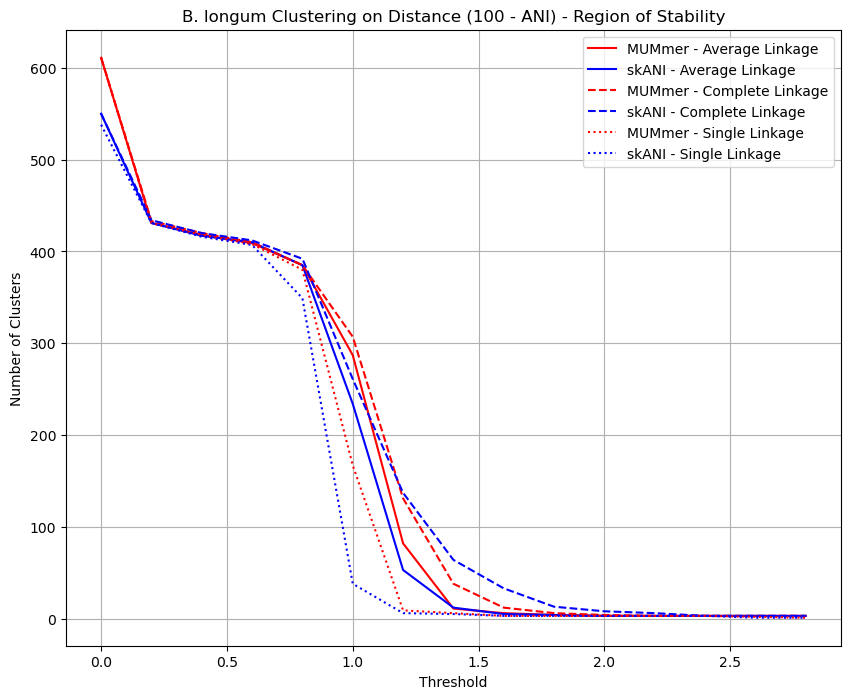

In [227]:
threshold_values = [i / 10 for i in range(0, 30, 2)]

mummer_results_avg, skani_results_avg = {}, {}
mummer_results_compl, skani_results_compl = {}, {}
mummer_results_single, skani_results_single = {}, {}

for threshold in threshold_values:
    # average
    mummer_res_a = get_clustered_matrix(mummer_dist_matrix, average, threshold, 'distance')
    skani_res_a = get_clustered_matrix(skani_dist_matrix, average, threshold, 'distance')

    mummer_clusters_a = mummer_res_a[1]
    skani_clusters_a = skani_res_a[1]

    num_mummer_clusters_a = len(set(mummer_clusters_a.values()))
    num_skani_clusters_a = len(set(skani_clusters_a.values()))

    mummer_results_avg[threshold] = num_mummer_clusters_a
    skani_results_avg[threshold] = num_skani_clusters_a

    # complete
    mummer_res_c = get_clustered_matrix(mummer_dist_matrix, complete, threshold, 'distance')
    skani_res_c = get_clustered_matrix(skani_dist_matrix, complete, threshold, 'distance')

    mummer_clusters_c = mummer_res_c[1]
    skani_clusters_c = skani_res_c[1]

    num_mummer_clusters_c = len(set(mummer_clusters_c.values()))
    num_skani_clusters_c = len(set(skani_clusters_c.values()))

    mummer_results_compl[threshold] = num_mummer_clusters_c
    skani_results_compl[threshold] = num_skani_clusters_c

    # single
    mummer_res_s = get_clustered_matrix(mummer_dist_matrix, single, threshold, 'distance')
    skani_res_s = get_clustered_matrix(skani_dist_matrix, single, threshold, 'distance')

    mummer_clusters_s = mummer_res_s[1]
    skani_clusters_s = skani_res_s[1]

    num_mummer_clusters_s = len(set(mummer_clusters_s.values()))
    num_skani_clusters_s = len(set(skani_clusters_s.values()))

    mummer_results_single[threshold] = num_mummer_clusters_s
    skani_results_single[threshold] = num_skani_clusters_s

plt.figure(figsize=(10, 8))

plt.plot(list(mummer_results_avg.keys()), list(mummer_results_avg.values()), 'r-', label='MUMmer - Average Linkage')
plt.plot(list(skani_results_avg.keys()), list(skani_results_avg.values()), 'b-', label='skANI - Average Linkage')

plt.plot(list(mummer_results_compl.keys()), list(mummer_results_compl.values()), 'r--', label='MUMmer - Complete Linkage')
plt.plot(list(skani_results_compl.keys()), list(skani_results_compl.values()), 'b--', label='skANI - Complete Linkage')

plt.plot(list(mummer_results_single.keys()), list(mummer_results_single.values()), 'r:', label='MUMmer - Single Linkage')
plt.plot(list(skani_results_single.keys()), list(skani_results_single.values()), 'b:', label='skANI - Single Linkage')

plt.title('B. longum Clustering on Distance (100 - ANI) - Region of Stability')
plt.xlabel('Threshold')
plt.ylabel('Number of Clusters')
plt.grid(True)
plt.legend(loc='best')
plt.show()

In [228]:
x_value = 3

def get_y_for_x(x_value, results_dict):
    x_points = list(results_dict.keys())
    y_points = list(results_dict.values())
    
    y_interpolated = np.interp(x_value, x_points, y_points)
    return y_interpolated

y_mummer_avg = get_y_for_x(x_value, mummer_results_avg)
y_skani_avg = get_y_for_x(x_value, skani_results_avg)

y_mummer_compl = get_y_for_x(x_value, mummer_results_compl)
y_skani_compl = get_y_for_x(x_value, skani_results_compl)

y_mummer_single = get_y_for_x(x_value, mummer_results_single)
y_skani_single = get_y_for_x(x_value, skani_results_single)

print(f"Y values for x = {x_value}:")
print(f"MUMmer - Average Linkage: {y_mummer_avg}")
print(f"skANI - Average Linkage: {y_skani_avg}")
print(f"MUMmer - Complete Linkage: {y_mummer_compl}")
print(f"skANI - Complete Linkage: {y_skani_compl}")
print(f"MUMmer - Single Linkage: {y_mummer_single}")
print(f"skANI - Single Linkage: {y_skani_single}")

Y values for x = 3:
MUMmer - Average Linkage: 3.0
skANI - Average Linkage: 3.0
MUMmer - Complete Linkage: 3.0
skANI - Complete Linkage: 3.0
MUMmer - Single Linkage: 1.0
skANI - Single Linkage: 1.0


In [229]:
def get_clusters_for_linkage(distance_matrix, linkage_function, threshold, tool_name, linkage_name):
    res = get_clustered_matrix(distance_matrix, linkage_function, threshold, 'distance')

    clusters = res[1]

    clusters_samples_dict = defaultdict(list)
    for sample, cluster_id in clusters.items():
        clusters_samples_dict[cluster_id].append(sample)

    # print(f"\nClusters for {tool_name} with {linkage_name} linkage at threshold {threshold}:")
    for cluster_id, samples in clusters_samples_dict.items():
        # print(f"Cluster {cluster_id}:")
        # for sample in samples:
        #     print(f"  {sample}")
        samples_array = np.array(samples)
        # print(f"Cluster {cluster_id}: {samples_array}")
    return clusters_samples_dict

tools = [
    (mummer_dist_matrix, 'MUMmer', [average, 'Average Linkage'], [complete, 'Complete Linkage'], [single, 'Single Linkage']),
    (skani_dist_matrix, 'skANI', [average, 'Average Linkage'], [complete, 'Complete Linkage'], [single, 'Single Linkage'])
]

for distance_matrix, tool_name, *linkages in tools:
    for linkage_function, linkage_name in linkages:
        get_clusters_for_linkage(distance_matrix, linkage_function, x_value, tool_name, linkage_name)

In [230]:
def get_subsp(clusters_samples_dict, subsp_dist_matrix):
    subsp_mapping = {}

    for cluster_id, samples in clusters_samples_dict.items():
        subspecies = set()

        for sample in samples:
            ref_match = subsp_dist_matrix[subsp_dist_matrix['ref'] == sample]
            query_match = subsp_dist_matrix[subsp_dist_matrix['query'] == sample]

            if not ref_match.empty:
                subsp = ref_match['gtdb_sb_ref'].iloc[0] if pd.notnull(ref_match['gtdb_sb_ref'].iloc[0]) else None
            elif not query_match.empty:
                subsp = query_match['gtdb_sb_ref'].iloc[0] if pd.notnull(query_match['gtdb_sb_ref'].iloc[0]) else None
            else:
                subsp = None

            if subsp:
                subspecies.add(subsp)

        subsp_mapping[cluster_id] = subspecies

    return subsp_mapping

linkages = [
    (average, 'Average Linkage'),
    (complete, 'Complete Linkage'),
    (single, 'Single Linkage')
]

for linkage_function, linkage_name in linkages:
    clusters_samples_dict = get_clusters_for_linkage(skani_dist_matrix, linkage_function, x_value, 'skANI', linkage_name)

    subspecies = get_subsp(clusters_samples_dict, subsp_dist_matrix)

    print(f"\nSubspecies within clusters for skANI - {linkage_name} at threshold = {x_value}:")
    for cluster_id, subsp in subspecies.items():
        print(f"Cluster {cluster_id}: {list(subsp)}")


Subspecies within clusters for skANI - Average Linkage at threshold = 3:
Cluster 3: ['longum', 'infantis']
Cluster 1: ['suis', 'longum', 'suillum']
Cluster 2: ['longum']

Subspecies within clusters for skANI - Complete Linkage at threshold = 3:
Cluster 3: ['longum', 'infantis']
Cluster 1: ['suis', 'longum', 'suillum']
Cluster 2: ['longum']

Subspecies within clusters for skANI - Single Linkage at threshold = 3:
Cluster 1: ['suis', 'longum', 'infantis', 'suillum']


COMPARING TOOLS

In [231]:
mummer_matrix_2 = mummer_matrix.copy()
mummer_matrix_2.rename(columns = {'avg_identity1':'ANI_1', 'avg_identity2':'ANI_2'}, inplace = True)
mummer_matrix_2

,prc_aligned1,prc_aligned2,ANI_1,ANI_2,s1,s2,Tool,score1,score2,ref,query
0,100.0000,100.0000,100.0000,100.0000,GCA_008668555.1,GCA_008668555.1,mummer,100.000000,100.000000,sample0,sample0
1,98.3926,95.0642,99.6903,99.6903,GCA_008668555.1,GCA_008668865.1,mummer,98.087878,94.769786,sample0,sample1
2,89.4098,85.5646,98.6762,98.6762,GCA_008668555.1,GCA_008669195.1,mummer,88.226193,84.431896,sample0,sample2
3,89.4810,86.9017,98.7474,98.7474,GCA_008668555.1,GCA_008670925.1,mummer,88.360161,85.813169,sample0,sample3
4,89.6553,84.5672,98.7345,98.7345,GCA_008668555.1,GCA_008671675.1,mummer,88.520712,83.497002,sample0,sample4
...,...,...,...,...,...,...,...,...,...,...,...
188800,83.4168,84.4135,98.6293,98.6293,flye.SQK-NBD114-96_barcode96,GCF_925297675.1,mummer,82.273406,83.256444,sample613,sample563
188801,76.9846,77.2749,97.1214,97.1214,flye.SQK-NBD114-96_barcode96,GCF_925300395.1,mummer,74.768521,75.050465,sample613,sample564
188802,76.9961,73.7162,96.7839,96.7839,flye.SQK-NBD114-96_barcode96,GCF_934630425.1,mummer,74.519828,71.345413,sample613,sample565
188803,83.5231,88.1633,98.8688,98.8688,flye.SQK-NBD114-96_barcode96,GCF_934675445.1,mummer,82.578287,87.165997,sample613,sample566


In [232]:
skani_matrix_2 = skani_matrix.copy()
skani_matrix_2.rename(columns = {'Ref_file': 's1', 'Query_file': 's2', 'ANI':'ANI_1', 'Align_fraction_ref': 'prc_aligned1', 'Align_fraction_query': 'prc_aligned2'}, inplace = True)
skani_matrix_2

,s1,s2,ANI_1,prc_aligned1,prc_aligned2,Ref_name,Query_name,Tool,score1,score2,ref,query
0,GCA_008668555.1,GCA_008668555.1,100.00,100.00,100.00,,,skANI,100.000000,100.000000,sample0,sample0
1,GCA_008668555.1,GCA_008668865.1,99.76,97.90,94.67,RQBZ01000002.1 MAG: Bifidobacterium longum iso...,RQBI01000075.1 MAG: Bifidobacterium longum iso...,skANI,97.665040,94.442792,sample0,sample1
2,GCA_008668555.1,GCA_008669195.1,98.70,87.73,84.17,RQBZ01000002.1 MAG: Bifidobacterium longum iso...,RQAF01000006.1 MAG: Bifidobacterium longum iso...,skANI,86.589510,83.075790,sample0,sample2
3,GCA_008668555.1,GCA_008670925.1,98.72,87.84,85.69,RQBZ01000002.1 MAG: Bifidobacterium longum iso...,RQAY01000057.1 MAG: Bifidobacterium longum iso...,skANI,86.715648,84.593168,sample0,sample3
4,GCA_008668555.1,GCA_008671675.1,98.85,87.50,82.94,RQBZ01000002.1 MAG: Bifidobacterium longum iso...,RPXW01000045.1 MAG: Bifidobacterium longum iso...,skANI,86.493750,81.986190,sample0,sample4
...,...,...,...,...,...,...,...,...,...,...,...,...
188800,flye.SQK-NBD114-96_barcode96,GCF_925297675.1,98.51,82.08,83.11,contig_1 rotated=True rotated_gene=dnaA,NZ_CAKMBY010000001.1 Bifidobacterium longum su...,skANI,80.857008,81.871661,sample613,sample563
188801,flye.SQK-NBD114-96_barcode96,GCF_925300395.1,96.45,73.72,73.90,contig_1 rotated=True rotated_gene=dnaA,NZ_CAKMCL010000001.1 Bifidobacterium longum su...,skANI,71.102940,71.276550,sample613,sample564
188802,flye.SQK-NBD114-96_barcode96,GCF_934630425.1,96.67,72.80,69.48,contig_1 rotated=True rotated_gene=dnaA,NZ_CAKTVT010000001.1 MAG: uncultured Bifidobac...,skANI,70.375760,67.166316,sample613,sample565
188803,flye.SQK-NBD114-96_barcode96,GCF_934675445.1,98.86,82.59,86.98,contig_1 rotated=True rotated_gene=dnaA,NZ_CAKUQL010000001.1 MAG: uncultured Bifidobac...,skANI,81.648474,85.988428,sample613,sample566


In [233]:
parsnp_matrix_2 = parsnp_matrix.copy()
parsnp_matrix_2.rename(columns = {'p1': 's1', 'p2': 's2'}, inplace = True)
parsnp_matrix_2

,s1,s2,diff,prc,Tool,ANI_1,ref,query,alignment_size
0,GCA_008668555.1,GCA_008668555.1,0,0.000000,ParSNP,100.000000,sample0,sample0,NaN
1,GCA_008668555.1,GCA_008668865.1,824,1.754199,ParSNP,98.245801,sample0,sample1,46973.0
2,GCA_008668555.1,GCA_008669195.1,2334,4.968812,ParSNP,95.031188,sample0,sample2,46973.0
3,GCA_008668555.1,GCA_008670925.1,2345,4.992230,ParSNP,95.007770,sample0,sample3,46973.0
4,GCA_008668555.1,GCA_008672355.1,2494,5.309433,ParSNP,94.690567,sample0,sample7,46973.0
...,...,...,...,...,...,...,...,...,...
189414,flye.SQK-NBD114-96_barcode96,flye.SQK-NBD114-96_barcode77,157,0.334235,ParSNP,99.665765,sample613,sample594,46973.0
189415,flye.SQK-NBD114-96_barcode96,flye.SQK-NBD114-96_barcode80,2058,4.381240,ParSNP,95.618760,sample613,sample597,46973.0
189416,flye.SQK-NBD114-96_barcode96,flye.SQK-NBD114-96_barcode82,1985,4.225832,ParSNP,95.774168,sample613,sample599,46973.0
189417,flye.SQK-NBD114-96_barcode96,flye.SQK-NBD114-96_barcode94,331,0.704660,ParSNP,99.295340,sample613,sample611,46973.0


In [234]:
all_tools_df = pd.concat([mummer_matrix_2, skani_matrix_2, parsnp_matrix_2], ignore_index=True)
all_tools_df.rename(columns={'score1': 'aligned_bases'}, inplace=True)
all_tools_df

,prc_aligned1,prc_aligned2,ANI_1,ANI_2,s1,s2,Tool,aligned_bases,score2,ref,query,Ref_name,Query_name,diff,prc,alignment_size
0,100.0000,100.0000,100.000000,100.0000,GCA_008668555.1,GCA_008668555.1,mummer,100.000000,100.000000,sample0,sample0,NaN,NaN,NaN,NaN,NaN
1,98.3926,95.0642,99.690300,99.6903,GCA_008668555.1,GCA_008668865.1,mummer,98.087878,94.769786,sample0,sample1,NaN,NaN,NaN,NaN,NaN
2,89.4098,85.5646,98.676200,98.6762,GCA_008668555.1,GCA_008669195.1,mummer,88.226193,84.431896,sample0,sample2,NaN,NaN,NaN,NaN,NaN
3,89.4810,86.9017,98.747400,98.7474,GCA_008668555.1,GCA_008670925.1,mummer,88.360161,85.813169,sample0,sample3,NaN,NaN,NaN,NaN,NaN
4,89.6553,84.5672,98.734500,98.7345,GCA_008668555.1,GCA_008671675.1,mummer,88.520712,83.497002,sample0,sample4,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567024,NaN,NaN,99.665765,NaN,flye.SQK-NBD114-96_barcode96,flye.SQK-NBD114-96_barcode77,ParSNP,NaN,NaN,sample613,sample594,NaN,NaN,157.0,0.334235,46973.0
567025,NaN,NaN,95.618760,NaN,flye.SQK-NBD114-96_barcode96,flye.SQK-NBD114-96_barcode80,ParSNP,NaN,NaN,sample613,sample597,NaN,NaN,2058.0,4.381240,46973.0
567026,NaN,NaN,95.774168,NaN,flye.SQK-NBD114-96_barcode96,flye.SQK-NBD114-96_barcode82,ParSNP,NaN,NaN,sample613,sample599,NaN,NaN,1985.0,4.225832,46973.0
567027,NaN,NaN,99.295340,NaN,flye.SQK-NBD114-96_barcode96,flye.SQK-NBD114-96_barcode94,ParSNP,NaN,NaN,sample613,sample611,NaN,NaN,331.0,0.704660,46973.0


In [235]:
melted_df = pd.melt(all_tools_df, id_vars=['Tool'], value_vars=['ANI_1', 'aligned_bases'], var_name='Type', value_name='ANI')
melted_df

,Tool,Type,ANI
0,mummer,ANI_1,100.0000
1,mummer,ANI_1,99.6903
2,mummer,ANI_1,98.6762
3,mummer,ANI_1,98.7474
4,mummer,ANI_1,98.7345
...,...,...,...
1134053,ParSNP,aligned_bases,NaN
1134054,ParSNP,aligned_bases,NaN
1134055,ParSNP,aligned_bases,NaN
1134056,ParSNP,aligned_bases,NaN


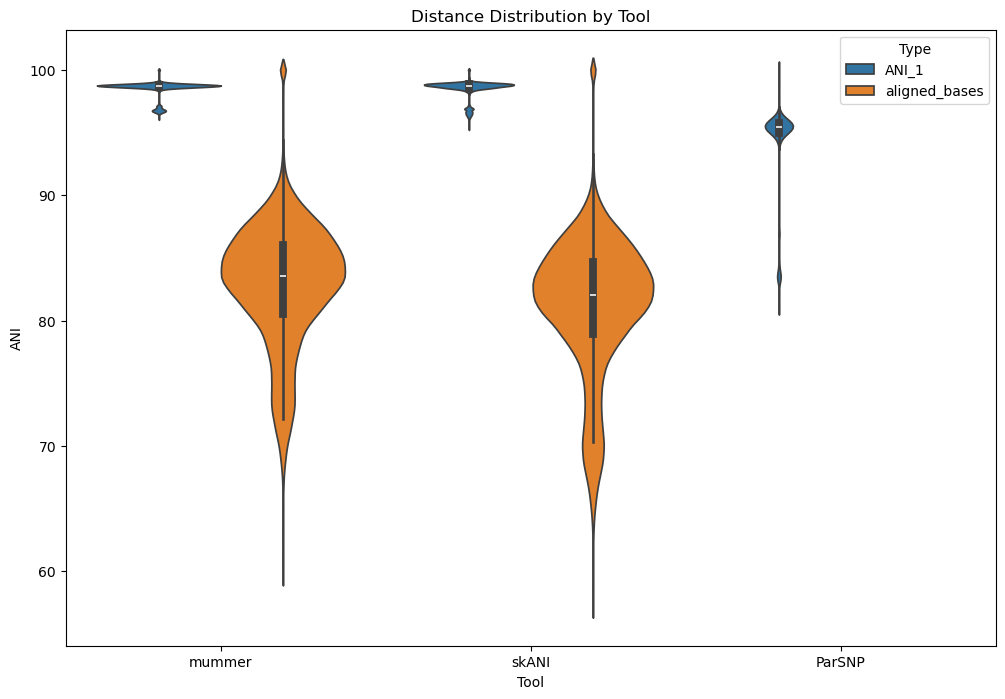

In [236]:
plt.figure(figsize=(12, 8))
sns.violinplot(data=melted_df, x='Tool', y='ANI', hue='Type')
plt.title('Distance Distribution by Tool')
plt.show()

In [237]:
filtered_melted_df = melted_df[melted_df['Type'] == 'ANI_1']
filtered_melted_df

,Tool,Type,ANI
0,mummer,ANI_1,100.000000
1,mummer,ANI_1,99.690300
2,mummer,ANI_1,98.676200
3,mummer,ANI_1,98.747400
4,mummer,ANI_1,98.734500
...,...,...,...
567024,ParSNP,ANI_1,99.665765
567025,ParSNP,ANI_1,95.618760
567026,ParSNP,ANI_1,95.774168
567027,ParSNP,ANI_1,99.295340


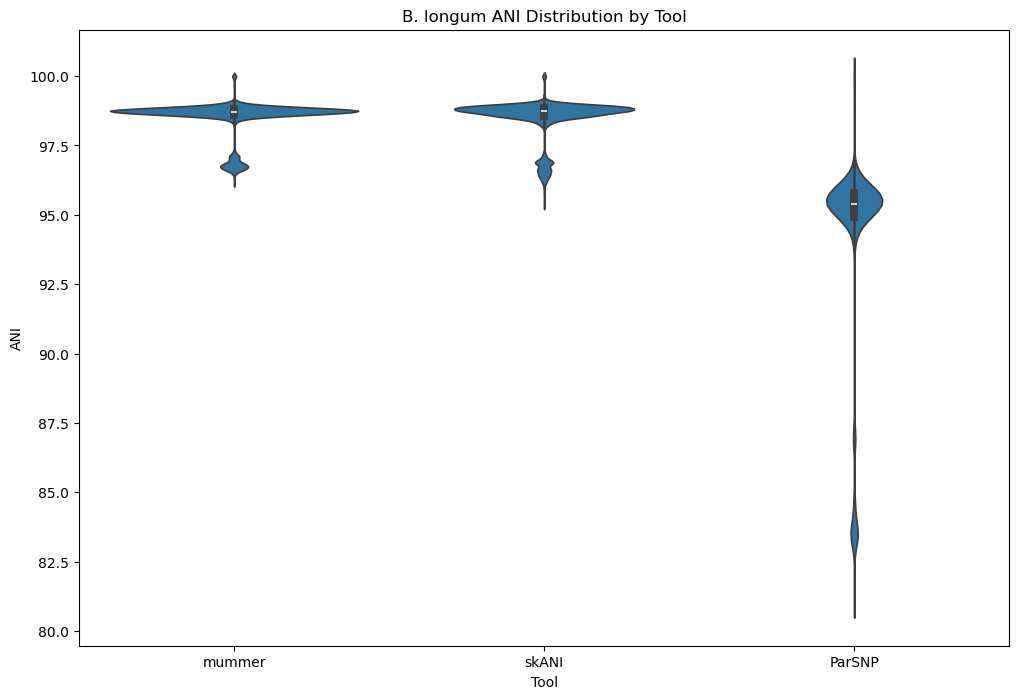

In [238]:
plt.figure(figsize=(12, 8))
sns.violinplot(data=filtered_melted_df, x='Tool', y='ANI')
plt.title('B. longum ANI Distribution by Tool')
plt.show()

In [239]:
regplot_df = pd.DataFrame({'mummer_ref': mummer_matrix['s1'],
                           'skani_ref': skani_matrix['Ref_file'],
                           'parsnp_ref': parsnp_matrix['p1'],
                           'mummer_query': mummer_matrix['s2'],
                           'skani_query': skani_matrix['Query_file'],
                           'parsnp_query': parsnp_matrix['p2'],
                           'mummer_ANI': mummer_matrix['avg_identity1'],
                           'skani_ANI': skani_matrix['ANI'],
                           'parsnp_ANI': parsnp_matrix['ANI_1']})
regplot_df

,mummer_ref,skani_ref,parsnp_ref,mummer_query,skani_query,parsnp_query,mummer_ANI,skani_ANI,parsnp_ANI
0,GCA_008668555.1,GCA_008668555.1,GCA_008668555.1,GCA_008668555.1,GCA_008668555.1,GCA_008668555.1,100.0000,100.00,100.000000
1,GCA_008668555.1,GCA_008668555.1,GCA_008668555.1,GCA_008668865.1,GCA_008668865.1,GCA_008668865.1,99.6903,99.76,98.245801
2,GCA_008668555.1,GCA_008668555.1,GCA_008668555.1,GCA_008669195.1,GCA_008669195.1,GCA_008669195.1,98.6762,98.70,95.031188
3,GCA_008668555.1,GCA_008668555.1,GCA_008668555.1,GCA_008670925.1,GCA_008670925.1,GCA_008670925.1,98.7474,98.72,95.007770
4,GCA_008668555.1,GCA_008668555.1,GCA_008668555.1,GCA_008671675.1,GCA_008671675.1,GCA_008672355.1,98.7345,98.85,94.690567
...,...,...,...,...,...,...,...,...,...
189414,NaN,NaN,flye.SQK-NBD114-96_barcode96,NaN,NaN,flye.SQK-NBD114-96_barcode77,NaN,NaN,99.665765
189415,NaN,NaN,flye.SQK-NBD114-96_barcode96,NaN,NaN,flye.SQK-NBD114-96_barcode80,NaN,NaN,95.618760
189416,NaN,NaN,flye.SQK-NBD114-96_barcode96,NaN,NaN,flye.SQK-NBD114-96_barcode82,NaN,NaN,95.774168
189417,NaN,NaN,flye.SQK-NBD114-96_barcode96,NaN,NaN,flye.SQK-NBD114-96_barcode94,NaN,NaN,99.295340


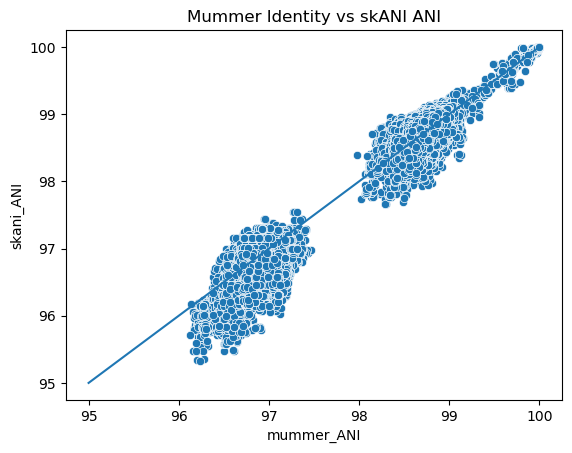

In [240]:
sns.scatterplot(data=regplot_df, x='mummer_ANI', y='skani_ANI')
plt.plot([95, 100], [95, 100])
plt.title("Mummer Identity vs skANI ANI")
plt.show()

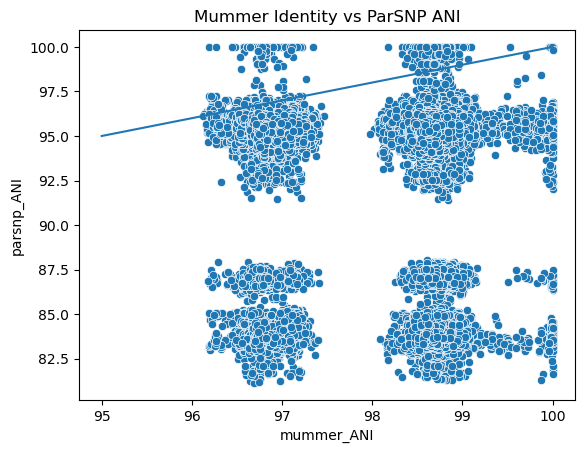

In [241]:
sns.scatterplot(data=regplot_df, x='mummer_ANI', y='parsnp_ANI')
plt.plot([95, 100], [95, 100])
plt.title("Mummer Identity vs ParSNP ANI")
plt.show()

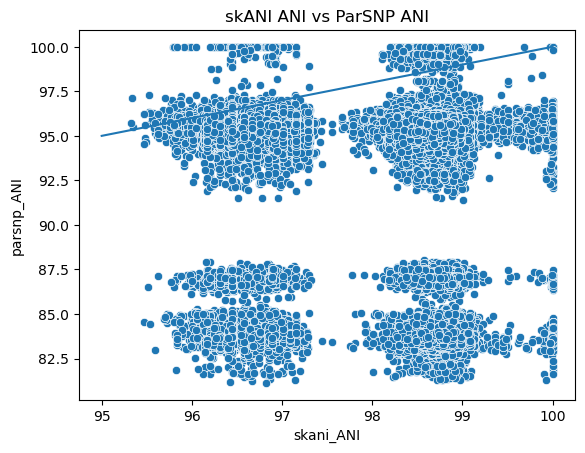

In [242]:
sns.scatterplot(data=regplot_df, x='skani_ANI', y='parsnp_ANI')
plt.plot([95, 100], [95, 100])
plt.title("skANI ANI vs ParSNP ANI")
plt.show()

DEREPLICATION TOOL COMPARISON

In [243]:
skder_matrix = pd.read_csv(skder_file_path, sep='\t')
skder_matrix['tool'] = 'skder'

skder_matrix['genome'] = skder_matrix['genome'].apply(edit_accession_id)
skder_matrix['nearest_representative_genome'] = skder_matrix['nearest_representative_genome'].apply(edit_accession_id)

skder_matrix.rename(columns={"nearest_representative_genome": "nearest_representative_genome(s)"}, inplace=True)

skder_matrix

,genome,nearest_representative_genome(s),average_nucleotide_identity,alignment_fraction,match_category,tool
0,GCF_016759745.1,GCF_016759745.1,100.00,100.00,representative_to_self,skder
1,GCF_016759755.1,GCF_016759755.1,100.00,100.00,representative_to_self,skder
2,GCF_016759825.1,GCF_016759825.1,100.00,100.00,representative_to_self,skder
3,GCF_016838685.1,GCF_016838685.1,100.00,100.00,representative_to_self,skder
4,GCF_017132755.1,GCF_017132755.1,100.00,100.00,representative_to_self,skder
...,...,...,...,...,...,...
608,flye.SQK-NBD114-96_barcode87,GCF_019128495.1,99.07,86.68,outside_cutoffs_requested,skder
609,flye.SQK-NBD114-96_barcode70,GCF_019128495.1,99.07,86.62,outside_cutoffs_requested,skder
610,flye.SQK-NBD114-96_barcode84,flye.SQK-NBD114-96_barcode51,99.09,89.27,outside_cutoffs_requested,skder
611,flye.SQK-NBD114-96_barcode67,flye.SQK-NBD114-96_barcode51,99.32,89.15,outside_cutoffs_requested,skder


In [244]:
len(skder_matrix['nearest_representative_genome(s)'].unique())

223

In [245]:
# new_skder_matrix = skder_matrix.groupby('nearest_representative_genome', group_keys=True)[['average_nucleotide_identity']].apply(lambda x: x)

skder_genome_counts = skder_matrix['nearest_representative_genome(s)'].value_counts()
skder_matrix['cluster_size'] = skder_matrix['nearest_representative_genome(s)'].map(skder_genome_counts).fillna(0).astype(int)
skder_matrix

,genome,nearest_representative_genome(s),average_nucleotide_identity,alignment_fraction,match_category,tool,cluster_size
0,GCF_016759745.1,GCF_016759745.1,100.00,100.00,representative_to_self,skder,1
1,GCF_016759755.1,GCF_016759755.1,100.00,100.00,representative_to_self,skder,2
2,GCF_016759825.1,GCF_016759825.1,100.00,100.00,representative_to_self,skder,3
3,GCF_016838685.1,GCF_016838685.1,100.00,100.00,representative_to_self,skder,4
4,GCF_017132755.1,GCF_017132755.1,100.00,100.00,representative_to_self,skder,4
...,...,...,...,...,...,...,...
608,flye.SQK-NBD114-96_barcode87,GCF_019128495.1,99.07,86.68,outside_cutoffs_requested,skder,21
609,flye.SQK-NBD114-96_barcode70,GCF_019128495.1,99.07,86.62,outside_cutoffs_requested,skder,21
610,flye.SQK-NBD114-96_barcode84,flye.SQK-NBD114-96_barcode51,99.09,89.27,outside_cutoffs_requested,skder,31
611,flye.SQK-NBD114-96_barcode67,flye.SQK-NBD114-96_barcode51,99.32,89.15,outside_cutoffs_requested,skder,31


In [246]:
skder_genome_counts.describe()

count    223.000000
mean       2.748879
std        4.008964
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max       39.000000
Name: count, dtype: float64

In [247]:
skder_sample_names = sorted(set(skder_matrix['genome']) | set(skder_matrix['nearest_representative_genome(s)']))
skder_mapper = {name: f'sample{idx}' for idx, name in enumerate(skder_sample_names)}

skder_matrix['ref'] = skder_matrix['genome'].map(skder_mapper)
skder_matrix['query'] = skder_matrix['nearest_representative_genome(s)'].map(skder_mapper)

In [248]:
skder_clusters = skder_matrix.query('cluster_size != 0')
skder_clusters

,genome,nearest_representative_genome(s),average_nucleotide_identity,alignment_fraction,match_category,tool,cluster_size,ref,query
0,GCF_016759745.1,GCF_016759745.1,100.00,100.00,representative_to_self,skder,1,sample408,sample408
1,GCF_016759755.1,GCF_016759755.1,100.00,100.00,representative_to_self,skder,2,sample409,sample409
2,GCF_016759825.1,GCF_016759825.1,100.00,100.00,representative_to_self,skder,3,sample412,sample412
3,GCF_016838685.1,GCF_016838685.1,100.00,100.00,representative_to_self,skder,4,sample414,sample414
4,GCF_017132755.1,GCF_017132755.1,100.00,100.00,representative_to_self,skder,4,sample416,sample416
...,...,...,...,...,...,...,...,...,...
608,flye.SQK-NBD114-96_barcode87,GCF_019128495.1,99.07,86.68,outside_cutoffs_requested,skder,21,sample603,sample464
609,flye.SQK-NBD114-96_barcode70,GCF_019128495.1,99.07,86.62,outside_cutoffs_requested,skder,21,sample586,sample464
610,flye.SQK-NBD114-96_barcode84,flye.SQK-NBD114-96_barcode51,99.09,89.27,outside_cutoffs_requested,skder,31,sample600,sample568
611,flye.SQK-NBD114-96_barcode67,flye.SQK-NBD114-96_barcode51,99.32,89.15,outside_cutoffs_requested,skder,31,sample583,sample568


In [249]:
cidder_matrix = pd.read_csv(cidder_file_path, sep='\t')
cidder_matrix['tool'] = 'cidder'

cidder_matrix['genome'] = cidder_matrix['genome'].apply(edit_accession_id)
cidder_matrix['nearest_representative_genome(s)'] = cidder_matrix['nearest_representative_genome(s)'].apply(edit_accession_id)

cidder_matrix.rename(columns={"max_containment_of_genome_protein_clusters": "average_nucleotide_identity"}, inplace=True)

cidder_matrix

,genome,nearest_representative_genome(s),average_nucleotide_identity,genome_protein_cluster_count,representative_genome_protein_cluster_count,tool
0,GCF_015558965.1,GCF_015558965.1,100.000000,2150,2150,cidder
1,GCF_016759745.1,GCF_016759745.1,100.000000,2033,2033,cidder
2,GCF_003370065.1,GCF_003370065.1,100.000000,1990,1990,cidder
3,GCF_004333475.1,GCF_004333475.1,100.000000,1910,1910,cidder
4,GCF_016759705.1,GCF_016759705.1,100.000000,2041,2041,cidder
...,...,...,...,...,...,...
608,GCA_019419305.1,GCF_004333515.1,86.235038,1838,1931,cidder
609,GCF_017291355.1,GCF_028898865.1,98.904928,2009,1931,cidder
610,GCF_003474905.1,GCF_030450025.1,82.438535,1993,1931,cidder
611,GCF_004333275.1,GCF_004333325.1,89.715190,1896,1931,cidder


In [250]:
len(cidder_matrix['nearest_representative_genome(s)'].unique())

275

In [251]:
cidder_genome_counts = cidder_matrix['nearest_representative_genome(s)'].value_counts()
cidder_matrix['cluster_size'] = cidder_matrix['nearest_representative_genome(s)'].map(cidder_genome_counts).fillna(0).astype(int)
cidder_matrix

,genome,nearest_representative_genome(s),average_nucleotide_identity,genome_protein_cluster_count,representative_genome_protein_cluster_count,tool,cluster_size
0,GCF_015558965.1,GCF_015558965.1,100.000000,2150,2150,cidder,2
1,GCF_016759745.1,GCF_016759745.1,100.000000,2033,2033,cidder,1
2,GCF_003370065.1,GCF_003370065.1,100.000000,1990,1990,cidder,1
3,GCF_004333475.1,GCF_004333475.1,100.000000,1910,1910,cidder,1
4,GCF_016759705.1,GCF_016759705.1,100.000000,2041,2041,cidder,2
...,...,...,...,...,...,...,...
608,GCA_019419305.1,GCF_004333515.1,86.235038,1838,1931,cidder,4
609,GCF_017291355.1,GCF_028898865.1,98.904928,2009,1931,cidder,6
610,GCF_003474905.1,GCF_030450025.1,82.438535,1993,1931,cidder,5
611,GCF_004333275.1,GCF_004333325.1,89.715190,1896,1931,cidder,2


In [252]:
cidder_genome_counts.describe()

count    275.000000
mean       2.229091
std        2.406323
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       25.000000
Name: count, dtype: float64

In [253]:
# cidder_clusters = cidder_matrix.query('cluster_size != 0')
# cidder_clusters

In [254]:
drep_matrix = pd.read_csv(drep_file_path)
drep_matrix['tool'] = 'drep'

drep_matrix['genome'] = drep_matrix['genome'].apply(edit_accession_id)

drep_matrix.groupby('secondary_cluster')

drep_matrix

,genome,secondary_cluster,threshold,cluster_method,comparison_algorithm,primary_cluster,tool
0,GCF_016759725.1,1_1,0.01,average,fastANI,1,drep
1,GCF_026520375.1,1_1,0.01,average,fastANI,1,drep
2,GCF_014900875.1,1_2,0.01,average,fastANI,1,drep
3,GCF_000421385.1,1_3,0.01,average,fastANI,1,drep
4,GCF_002833315.1,1_3,0.01,average,fastANI,1,drep
...,...,...,...,...,...,...,...
609,GCF_900157055.1,1_353,0.01,average,fastANI,1,drep
610,GCF_000786175.1,1_354,0.01,average,fastANI,1,drep
611,GCA_008673465.1,1_355,0.01,average,fastANI,1,drep
612,GCA_022713415.1,1_356,0.01,average,fastANI,1,drep


In [255]:
drep_num_clusters = len(drep_matrix['secondary_cluster'].unique())
drep_num_clusters

357

In [256]:
drep_genome_counts = drep_matrix['secondary_cluster'].value_counts()
drep_matrix['cluster_size'] = drep_matrix['secondary_cluster'].map(drep_genome_counts).fillna(0).astype(int)
drep_matrix

,genome,secondary_cluster,threshold,cluster_method,comparison_algorithm,primary_cluster,tool,cluster_size
0,GCF_016759725.1,1_1,0.01,average,fastANI,1,drep,2
1,GCF_026520375.1,1_1,0.01,average,fastANI,1,drep,2
2,GCF_014900875.1,1_2,0.01,average,fastANI,1,drep,1
3,GCF_000421385.1,1_3,0.01,average,fastANI,1,drep,2
4,GCF_002833315.1,1_3,0.01,average,fastANI,1,drep,2
...,...,...,...,...,...,...,...,...
609,GCF_900157055.1,1_353,0.01,average,fastANI,1,drep,1
610,GCF_000786175.1,1_354,0.01,average,fastANI,1,drep,1
611,GCA_008673465.1,1_355,0.01,average,fastANI,1,drep,1
612,GCA_022713415.1,1_356,0.01,average,fastANI,1,drep,1


In [257]:
drep_genome_counts.describe()

count    357.000000
mean       1.719888
std        2.203157
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       31.000000
Name: count, dtype: float64

In [258]:
galah_matrix = pd.read_csv(galah_file_path, sep='\t')
galah_matrix.columns = ['nearest_representative_genome(s)', 'genome']
galah_matrix['tool'] = 'galah'

galah_matrix['genome'] = galah_matrix['genome'].apply(edit_accession_id)
galah_matrix['nearest_representative_genome(s)'] = galah_matrix['nearest_representative_genome(s)'].apply(edit_accession_id)

galah_matrix

,nearest_representative_genome(s),genome,tool
0,GCF_028201535.1,GCF_028201535.1,galah
1,GCF_901873505.1,GCF_901873505.1,galah
2,GCF_014900875.1,GCF_014900875.1,galah
3,GCF_014900875.1,GCF_016759725.1,galah
4,GCF_014900875.1,GCF_026520375.1,galah
...,...,...,...
608,GCF_030291325.1,GCA_022713415.1,galah
609,GCF_030291325.1,GCF_003370095.1,galah
610,GCF_030291325.1,GCA_958439875.1,galah
611,GCF_030291325.1,GCA_014871865.1,galah


In [259]:
len(galah_matrix['genome'].unique()), len(galah_matrix['nearest_representative_genome(s)'].unique())

(613, 74)

In [260]:
galah_num_clusters = len(galah_matrix['nearest_representative_genome(s)'].unique())
galah_num_clusters

74

In [261]:
galah_genome_counts = galah_matrix['nearest_representative_genome(s)'].value_counts()
galah_matrix['cluster_size'] = galah_matrix['nearest_representative_genome(s)'].map(galah_genome_counts).fillna(0).astype(int)
galah_matrix

,nearest_representative_genome(s),genome,tool,cluster_size
0,GCF_028201535.1,GCF_028201535.1,galah,1
1,GCF_901873505.1,GCF_901873505.1,galah,1
2,GCF_014900875.1,GCF_014900875.1,galah,3
3,GCF_014900875.1,GCF_016759725.1,galah,3
4,GCF_014900875.1,GCF_026520375.1,galah,3
...,...,...,...,...
608,GCF_030291325.1,GCA_022713415.1,galah,8
609,GCF_030291325.1,GCF_003370095.1,galah,8
610,GCF_030291325.1,GCA_958439875.1,galah,8
611,GCF_030291325.1,GCA_014871865.1,galah,8


In [262]:
galah_matrix['nearest_representative_genome(s)'].value_counts().describe()

count     74.000000
mean       8.283784
std       17.526903
min        1.000000
25%        2.000000
50%        4.000000
75%        6.750000
max      135.000000
Name: count, dtype: float64

In [263]:
skder_num_clusters = skder_genome_counts.count()
cidder_num_clusters = cidder_genome_counts.count()

d = {"skder": [skder_num_clusters],
     "cidder": [cidder_num_clusters],
     "drep": [drep_num_clusters],
     "galah": [galah_num_clusters]}

derep_cl_count = pd.DataFrame(d)
derep_cl_count

,skder,cidder,drep,galah
0,223,275,357,74


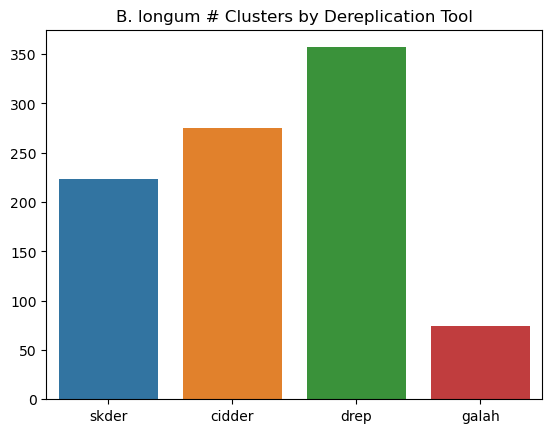

In [264]:
sns.barplot(derep_cl_count)
plt.title('B. longum # Clusters by Dereplication Tool')
plt.show()

In [265]:
# cidder_sample_names[346], skder_sample_names[346]

In [266]:
derep_merged_df = pd.concat([skder_matrix, cidder_matrix, drep_matrix, galah_matrix])
derep_merged_df

,genome,nearest_representative_genome(s),average_nucleotide_identity,alignment_fraction,match_category,tool,cluster_size,ref,query,genome_protein_cluster_count,representative_genome_protein_cluster_count,secondary_cluster,threshold,cluster_method,comparison_algorithm,primary_cluster
0,GCF_016759745.1,GCF_016759745.1,100.0,100.0,representative_to_self,skder,1,sample408,sample408,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,GCF_016759755.1,GCF_016759755.1,100.0,100.0,representative_to_self,skder,2,sample409,sample409,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,GCF_016759825.1,GCF_016759825.1,100.0,100.0,representative_to_self,skder,3,sample412,sample412,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,GCF_016838685.1,GCF_016838685.1,100.0,100.0,representative_to_self,skder,4,sample414,sample414,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,GCF_017132755.1,GCF_017132755.1,100.0,100.0,representative_to_self,skder,4,sample416,sample416,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608,GCA_022713415.1,GCF_030291325.1,NaN,NaN,NaN,galah,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
609,GCF_003370095.1,GCF_030291325.1,NaN,NaN,NaN,galah,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
610,GCA_958439875.1,GCF_030291325.1,NaN,NaN,NaN,galah,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
611,GCA_014871865.1,GCF_030291325.1,NaN,NaN,NaN,galah,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [267]:
median_cluster_sizes = derep_merged_df.groupby('tool')['cluster_size'].median().reset_index()
median_cluster_sizes

,tool,cluster_size
0,cidder,3.0
1,drep,2.0
2,galah,25.0
3,skder,4.0


In [268]:
mean_cluster_sizes = derep_merged_df.groupby('tool')['cluster_size'].mean().reset_index()
mean_cluster_sizes

,tool,cluster_size
0,cidder,4.817292
1,drep,4.534202
2,galah,44.866232
3,skder,8.569331


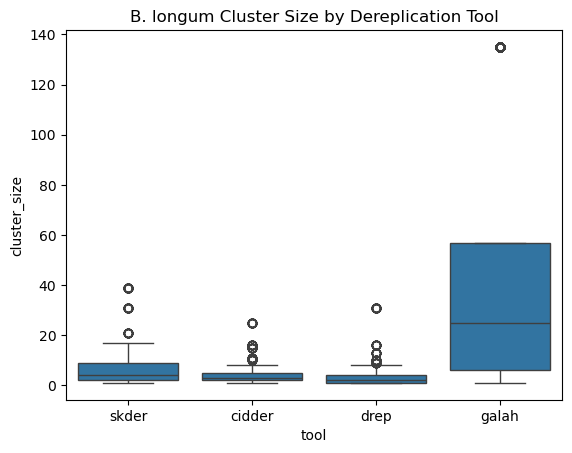

In [269]:
derep_boxplot = sns.boxplot(derep_merged_df,
                            x='tool',
                            y='cluster_size')
plt.title('B. longum Cluster Size by Dereplication Tool')
plt.show()

In [270]:
merged_df = skder_matrix[['genome', 'nearest_representative_genome(s)']].merge(
    cidder_matrix[['genome', 'nearest_representative_genome(s)']], on='genome', suffixes=('_skder', '_cidder')
).merge(
    drep_matrix[['genome', 'secondary_cluster']], on='genome'
).merge(
    galah_matrix[['genome', 'nearest_representative_genome(s)']], on='genome', suffixes=('_drep', '_galah')
)

tools = ['skder', 'cidder', 'drep', 'galah']
columns = ['nearest_representative_genome(s)_skder', 'nearest_representative_genome(s)_cidder', 
           'secondary_cluster', 'nearest_representative_genome(s)']

In [271]:
ari_results = []

for i in range(len(tools)):
    for j in range(i + 1, len(tools)):
        tool_1 = columns[i]
        tool_2 = columns[j]
        
        ari = adjusted_rand_score(merged_df[tool_1], merged_df[tool_2])
        
        ari_results.append({'tool 1': tools[i], 'tool 2': tools[j], 'ARI': ari})

ari_df = pd.DataFrame(ari_results)
ari_df

,tool 1,tool 2,ARI
0,skder,cidder,0.362605
1,skder,drep,0.493498
2,skder,galah,0.125379
3,cidder,drep,0.657806
4,cidder,galah,0.084588
5,drep,galah,0.118432


In [272]:
def create_pairwise_matrix(cluster_labels):
    n = len(cluster_labels)
    pairwise_matrix = pd.DataFrame(0, index=range(n), columns=range(n))
    
    for i in range(n):
        for j in range(i, n):
            if cluster_labels[i] == cluster_labels[j]:  # Same cluster
                pairwise_matrix.at[i, j] = 1
                pairwise_matrix.at[j, i] = 1
    return pairwise_matrix

def calculate_jaccard_index(pairwise_matrix_1, pairwise_matrix_2):
    matrix_1_flat = pairwise_matrix_1.values.flatten()
    matrix_2_flat = pairwise_matrix_2.values.flatten()
    
    return jaccard_score(matrix_1_flat, matrix_2_flat)

tools = ['skder', 'cidder', 'drep', 'galah']
columns = ['nearest_representative_genome(s)_skder', 'nearest_representative_genome(s)_cidder', 
           'secondary_cluster', 'nearest_representative_genome(s)']

jaccard_results = []

pairwise_matrices = {}
for tool, column in zip(tools, columns):
    pairwise_matrices[tool] = create_pairwise_matrix(merged_df[column].values)

for tool_1, tool_2 in combinations(tools, 2):
    pairwise_matrix_1 = pairwise_matrices[tool_1]
    pairwise_matrix_2 = pairwise_matrices[tool_2]
    
    jaccard_index = calculate_jaccard_index(pairwise_matrix_1, pairwise_matrix_2)
    
    jaccard_results.append({'tool 1': tool_1, 'tool 2': tool_2, 'Jaccard Index': jaccard_index})

jaccard_df = pd.DataFrame(jaccard_results)
jaccard_df

,tool 1,tool 2,Jaccard Index
0,skder,cidder,0.300571
1,skder,drep,0.402584
2,skder,galah,0.096424
3,cidder,drep,0.577876
4,cidder,galah,0.070379
5,drep,galah,0.088823
